## General Genelet Model

*Developed by: Samual Schaffter*

*Currently updated by: Kuan-Lin Chen*

- Used for screening for suitable comparators for gradient sensors

## RNase A:
- https://agscientific.com/blog/2019/05/rnase-a-faq/
- Recommended working concentration of RNase A is 1 to 100 µg/mL depending on the application. The enzyme is active under a wide range of reaction conditions. At low salt concentrations (0 to 100 mM NaCl), RNase A cleaves single-stranded and double-stranded RNA as well as RNA strand in RNA-DNA hybrids.

In [13]:
# Package importing
import os, copy, datetime
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

In [14]:
# Plotting setup
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
# Can later call color with cm.colors[i]
cm = plt.cm.get_cmap('tab20')
# Automatically plots
%matplotlib inline
# For Mac Retina Plots
%config InlineBackend.figure_format ='retina'

In [29]:
def con_vec2mat(con_vec, ortho_nodes, ind_nodes):
    '''
    This function converts connectivity vectors into connectivity matrices
    '''

    con_mat = np.zeros([ortho_nodes, ind_nodes], dtype = int)

    for n in range(len(con_vec)):
        if con_vec[n] != 0:
            con_mat[con_vec[n]-1, n] = 1

    return con_mat

def prod_vec2mat(prod_vec, ortho_nodes, ind_nodes):
    '''
    This function converts production vectors into production matrices
    '''

    Cprod_mat = np.zeros([ortho_nodes,ind_nodes], dtype = int)
    Rprod_mat = np.zeros([ortho_nodes,ind_nodes], dtype = int)

    for n in range(len(prod_vec)):
        if prod_vec[n] < 0:
            Rprod_mat[-prod_vec[n]-1, n] = 1
        elif prod_vec[n] > 0:
            Cprod_mat[prod_vec[n]-1,n] = 1

    return Cprod_mat, Rprod_mat

def int_genelet_states(G_int_vec, G_tot, act_vec, dA_tot):
    '''
    function to create genelet initial conditions
    '''

    GdAin = np.zeros(len(G_int_vec), dtype = int)
    GdBin = np.zeros(len(G_int_vec), dtype = int)
    dAin = copy.deepcopy(dA_tot)
    act_vec = np.array(act_vec)

    for n in range(len(G_int_vec)):

        # where there is more activator than total genelet of that activator
        if G_int_vec[n] == 1 and dAin[act_vec[n]-1] >= sum(G_tot[act_vec==act_vec[n]]):
            GdAin[n] = G_tot[n]
            dAin[act_vec[n]-1] = dAin[act_vec[n]-1] - G_tot[n]

        # where there is less activator than total genelet
        elif G_int_vec[n] == 1 and dAin[act_vec[n]-1] < sum(G_tot[act_vec==act_vec[n]]):
            # currently not sure how to handle this so an error will be printed
            print('Warning: Less activator than genelets!!!')
            '''GdAin[n] = dAin[act_vec[n]-1]/sum(act_vec==act_vec[n])
               dAin[act_vec[n]-1] = 0'''

        # blocked genelets
        # (excess blocker concentrations are handled in the simulation script)
        elif G_int_vec[n] == -1:
            GdBin[n] = G_tot[n]

    return GdAin, GdBin, dAin

def general_genelet_eqs(t,x,ortho_nodes,ind_nodes,dA_tot,dB_tot,G_tot, \
                        kpr,kpc,kpi,kd_H,kd_A,kga,kgar,kar,kgb,kgab,kgbc,kbc,kir, \
                        act_mat,rep_mat,blk_mat,ca_mat,Cprod_mat,Rprod_mat, \
                        Cindc_mat,Rindc_mat,RnH,RnA):
    """
    function containing the ODEs for the Kim and Winfree genelets (KWG)
    """

    k = ortho_nodes; g = ind_nodes

    # defining species for convenience
    rR = x[0: k] # repressors
    dA = x[k: 2*k] # activators
    rC = x[2*k: 3*k] # coactivators
    dB = x[3*k: 4*k] # blockers

    GdA = x[4*k: 4*k+g] # genelet:activator complexes
    GdB = x[4*k+g: 4*k+2*g] # genelet:blocker complexes

    rIr = x[4*k+2*g: 4*k+2*g+k] # repressor inducers
    rIc = x[4*k+2*g+k: 4*k+2*g+2*k] # coactivator inducers

    # mass balances to find other concentrations
    dArR = dA_tot - dA - np.matmul(act_mat,GdA) # activator:repressor complexes
    dBrC = dB_tot - dB - np.matmul(blk_mat,GdB) # blocker:coactivator complexes
    G = G_tot - GdA - GdB # OFF genelets

    # Rate equations:

    # repressors
    dRdt = -kgar*(np.matmul(rep_mat,GdA))*rR - kar*dA*rR + kpr*(np.matmul(Rprod_mat,GdA)) - kir*rR*rIr - RnA*kd_A*rR

    # activators
    dAdt = RnH*kd_H*dArR+ RnA*kd_A*dArR - kga*(np.matmul(act_mat,G))*dA - kar*dA*rR + kgab*(np.matmul(blk_mat,GdA))*dB

    # coactivators
    dCdt = -kgbc*(np.matmul(ca_mat,GdB))*rC - kbc*dB*rC + kpc*(np.matmul(Cprod_mat,GdA)) - kir*rC*rIc - RnA*kd_A*rC

    # blockers
    dBdt = RnH*kd_H*dBrC + RnA*kd_A*dBrC - kgb*(np.matmul(blk_mat,G))*dB - kbc*dB*rC - kgab*(np.matmul(blk_mat,GdA))*dB

    # G (ON)
    dGondt = (np.matmul(np.transpose(act_mat),(kga*dA)))*G - (np.matmul(np.transpose(rep_mat),(kgar*rR)))*GdA - (np.matmul(np.transpose(blk_mat),(kgab*dB)))*GdA

    #G (BLK)
    dGblkdt = (np.matmul(np.transpose(blk_mat),(kgb*dB)))*G + (np.matmul(np.transpose(blk_mat),(kgab*dB)))*GdA - (np.matmul(np.transpose(ca_mat),(kgbc*rC)))*GdB

    # repressor inducers
    dIrdt = kpi*(np.matmul(Rindc_mat,GdA)) - kir*rR*rIr - RnA*kd_A*rIr

    # coactivator inducers
    dIcdt = kpi*(np.matmul(Cindc_mat,GdA)) - kir*rC*rIc - RnA*kd_A*rIc

    return np.concatenate([dRdt,dAdt,dCdt,dBdt,dGondt,dGblkdt,dIrdt,dIcdt])

# function containing the ODEs for spatiotemporal genelets (STG)
def spatial_genelet_eqs(t,x,ortho_nodes,ind_nodes,dA_tot,G_tot, \
                        kpr,kpi,kd_H,kd_A,kd_Hg,kd_Ag,kga,kgar,kar,kir, \
                        act_mat,rep_mat,Rprod_mat,Rindc_mat,RnH,RnA):

    k = ortho_nodes
    g = ind_nodes

    # defining species for convenience
    rR = x[0: k] # repressors
    dA = x[k: 2*k] # activators

    Gon = x[2*k: 2*k+g] # active genelets complexes

    rIr = x[2*k+g: 2*k+g+k] # repressor inducers

    # mass balances to find other concentrations
    dArR = dA_tot - dA # free activator:repressor complexes
    GrR = G_tot - Gon # OFF genelets

    # Rate equations:

    # repressors
    dRdt = -kgar*(np.matmul(rep_mat,Gon))*rR - kar*dA*rR + kpr*(np.matmul(Rprod_mat,Gon)) - kir*rR*rIr - RnA*kd_A*rR

    # activators, aka threshold
    dAdt = RnH*kd_H*dArR + RnA*kd_A*dArR - kar*dA*rR

    # G (ON)
    dGondt = RnH*kd_Hg*GrR + RnA*kd_Ag*GrR - (np.matmul(np.transpose(rep_mat),(kgar*rR)))*Gon

    # repressor inducers
    dIrdt = kpi*(np.matmul(Rindc_mat,Gon)) - kir*rR*rIr - RnA*kd_A*rIr

    return np.concatenate([dRdt,dAdt,dGondt,dIrdt])


class GeneletNetwork:
    def __init__(self, act_vec, prod_vec, indc_vec, blk_vec=[], genelet_type = 'KWG'):

        self.genelet_type = genelet_type

        self.act_vec = act_vec

        self.ortho_nodes = max(self.act_vec)
        self.ind_nodes = len(self.act_vec)

        if blk_vec == []:
            blk_vec=np.zeros(self.ind_nodes, dtype = int)

        self.blk_vec = blk_vec

        self.rep_vec = copy.deepcopy(self.act_vec)
        self.ca_vec = copy.deepcopy(self.blk_vec)

        # Connectivity matrices
        self.act_mat = con_vec2mat(self.act_vec,self.ortho_nodes,self.ind_nodes)
        self.blk_mat = con_vec2mat(self.blk_vec,self.ortho_nodes,self.ind_nodes)
        self.rep_mat = con_vec2mat(self.rep_vec,self.ortho_nodes,self.ind_nodes)
        self.ca_mat = con_vec2mat(self.ca_vec,self.ortho_nodes,self.ind_nodes)

        # Production vectors
        self.prod_vec = prod_vec
        self.indc_vec = indc_vec

        # defining the production matrices
        [self.Cprod_mat,self.Rprod_mat] = prod_vec2mat(self.prod_vec,self.ortho_nodes,self.ind_nodes)
        [self.Cindc_mat,self.Rindc_mat] = prod_vec2mat(self.indc_vec,self.ortho_nodes,self.ind_nodes)


    ''' DEFINING INITIAL CONDITIONS '''
    def initial_conditions(self,dA_tot,G_tot,G_int_vec=[],dB_added=[],rRin=[],rCin=[],rIrin=[],rIcin=[]):

         # default initial genelet states are ON (especially for STG genelets)
        if G_int_vec == []:
            G_int_vec=[1]*self.ortho_nodes

        # defining default zero values for all of these inputs
        if dB_added == []:
            dB_added=np.zeros(self.ortho_nodes, dtype = int)
        if rRin == []:
            rRin=np.zeros(self.ortho_nodes, dtype = int)
        if rCin == []:
            rCin=np.zeros(self.ortho_nodes, dtype = int)
        if rIrin == []:
            rIrin=np.zeros(self.ortho_nodes, dtype = int)
        if rIcin == []:
            rIcin=np.zeros(self.ortho_nodes, dtype = int)

        self.dA_tot = dA_tot # total activator added

        self.G_tot = G_tot # total genelet added

        # initial genelet states (0 = OFF, 1 = ON, -1 = BLK)
        self.G_int_vec = G_int_vec

        if self.genelet_type.lower() == 'kwg':

            [self.GdAin,self.GdBin,self.dAin] = int_genelet_states(self.G_int_vec,self.G_tot,self.act_vec,self.dA_tot)

            self.dB_anneal = np.matmul(self.blk_mat,self.GdBin) # blocker attached to the annealed genelets
            self.dB_ex_anneal = 0.5*self.dB_anneal # excess blocker from the anneal
            self.dB_added = dB_added # added blocker beyond that present from the anneal
            self.dB_tot = self.dB_anneal + self.dB_ex_anneal + self.dB_added # total blocker present

            self.rRin = rRin # initial repressor concentration
            self.rCin = rCin # initial coactivator concentration
            self.dBin = self.dB_ex_anneal + self.dB_added # initial free blocker concentration
            self.rIrin = rIrin # initial repressor inducer concentration
            self.rIcin = rIcin # initial coactivator inducer concentration

            # final initial conditions
            self.int_cond = np.concatenate([self.rRin,self.dAin,self.rCin,\
                                            self.dBin,self.GdAin,self.GdBin,\
                                            self.rIrin,self.rIcin])

        elif self.genelet_type.lower() == 'stg':
        # be careful here about excess activator and repressors when setting inital contions
            self.Gon=np.zeros(self.ind_nodes, dtype = int)

            for i in range(len(self.G_int_vec)):
                if self.G_int_vec[i] == 1:
                    self.Gon[i] = self.G_tot[i]

            self.rRin = rRin # initial repressor concentration
            self.rIrin = rIrin # initial repressor inducer concentration

            # final initial conditions
            self.int_cond = np.concatenate([self.rRin,self.dA_tot,self.Gon,self.rIrin])


    ''' DEFINING PARAMETERS FOR SIMULATION AND SIMULATING MODEL '''
    def simulate(self,t_vec,iteration,rnase='rnh',rR=[],dA=[],rC=[],dB=[],rIr=[],rIc=[]):
        ''' Currently there is no capability to add genelet species mid experiment
            to add more G then update G_tot and to add GdB update G_tot and dB_tot
        '''
        # defining which rnases are being used in the simulation
        if rnase.lower() == 'rnh':
            RnH = 1
            RnA = 0
        elif rnase.lower() == 'rna':
            RnH = 0
            RnA = 1
        elif rnase.lower() == 'both':
            RnH = 1
            RnA = 1

        # defining the rate constants (not sure the best place to put these?)
        self.kpr = 0.02*np.ones(self.ortho_nodes) # repressor production rates
        self.kpc = 0.02*np.ones(self.ortho_nodes) # coactivator production rates
        self.kpi = 0.02*np.ones(self.ortho_nodes) # inducer production rates
        self.kd_H = 0.0003*np.ones(self.ortho_nodes) # RNaseH degradation rates
        self.kd_A = 0.000003*np.ones(self.ortho_nodes) # RNaseA degradation rates
        self.kga = 1e4*np.ones(self.ortho_nodes)/1e9 # activation rates
        self.kgar = 5e3*np.ones(self.ortho_nodes)/1e9 # repression rates
        self.kar = 1e4*np.ones(self.ortho_nodes)/1e9 # activator inhibition rates
        self.kgb = 1e4*np.ones(self.ortho_nodes)/1e9 # free blocking rates
        self.kgbc = 5e3*np.ones(self.ortho_nodes)/1e9 # coactivation rates
        self.kbc = 1e4*np.ones(self.ortho_nodes)/1e9 # blocker inhibition rates
        self.kgab = 5e3*np.ones(self.ortho_nodes)/1e9 # active blocking rates
        self.kir = 1e4*np.ones(self.ortho_nodes)/1e9 # inducer binding rates

        # RNase degradation rates for RNAs bound to spatiotemporal genelets
        self.kd_Hg = 0.0003*np.ones(self.ind_nodes)
        self.kd_Ag = 0.0003*np.ones(self.ind_nodes)

        k = self.ortho_nodes
        g = self.ind_nodes

        if iteration == 1:

            # calling the ODE equations
            # here this is operating only on the initial conditions
            if self.genelet_type.lower() == 'kwg':
                # using the rate equations for the Kim and Winfree genelets
                self.rates = lambda t, x: general_genelet_eqs(t,x, \
                                self.ortho_nodes,self.ind_nodes,self.dA_tot,self.dB_tot, \
                                self.G_tot,self.kpr,self.kpc,self.kpi,self.kd_H,self.kd_A, \
                                self.kga,self.kgar,self.kar,self.kgb,self.kgab,self.kgbc, \
                                self.kbc,self.kir,self.act_mat,self.rep_mat,self.blk_mat, \
                                self.ca_mat,self.Cprod_mat,self.Rprod_mat,self.Cindc_mat,self.Rindc_mat, \
                                RnH,RnA)

                # creating a new instance of the dA_tot and dB_tot variables for any additional sim steps
                self.dA_tot_n = copy.deepcopy(self.dA_tot)
                self.dB_tot_n = copy.deepcopy(self.dB_tot)

            elif self.genelet_type.lower() == 'stg':
                # using the rate equations for the spatiotemporal genelets
                self.rates = lambda t, x: spatial_genelet_eqs(t,x, \
                        self.ortho_nodes,self.ind_nodes,self.dA_tot,self.G_tot, \
                        self.kpr,self.kpi,self.kd_H,self.kd_A,self.kd_Hg,self.kd_Ag, \
                        self.kga,self.kgar,self.kar,self.kir,self.act_mat,self.rep_mat, \
                        self.Rprod_mat,self.Rindc_mat,RnH,RnA)

                # creating a new instance of the dA_tot and dB_tot variables for any additional sim steps
                self.dA_tot_n = copy.deepcopy(self.dA_tot)

            # time interval for simulation
            t = t_vec # seconds

            # solving the ODEs
            self.sol = spi.solve_ivp(self.rates,[t[0],t[-1]],self.int_cond,t_eval=t)


        elif iteration > 1:

            # time interval for simulation
            t_n = t_vec # seconds

            # the initial conditions are now the last values of the previous
            int_cond_n = self.sol.y[:,-1]

            # calling the ODE equations
            # here this is operating on any updated conditions wrt dA_tot and dB_tot
            if self.genelet_type.lower() == 'kwg':
                # using the rate equations and updating conditions for the Kim and Winfree genelets
                self.rates_n = lambda t, x: general_genelet_eqs(t,x, \
                                self.ortho_nodes,self.ind_nodes,self.dA_tot_n,self.dB_tot_n, \
                                self.G_tot,self.kpr,self.kpc,self.kpi,self.kd_H,self.kd_A, \
                                self.kga,self.kgar,self.kar,self.kgb,self.kgab,self.kgbc, \
                                self.kbc,self.kir,self.act_mat,self.rep_mat,self.blk_mat, \
                                self.ca_mat,self.Cprod_mat,self.Rprod_mat,self.Cindc_mat,self.Rindc_mat, \
                                RnH,RnA)

                # defining individual species for convenience below
                rR_n = int_cond_n[0:k] # repressors
                dA_n = int_cond_n[k:2*k] # activators
                rC_n = int_cond_n[2*k:3*k] # coactivators
                dB_n = int_cond_n[3*k:4*k] # blockers

                GdA_n = int_cond_n[4*k:4*k+g] # genelet:activator complexes
                GdB_n = int_cond_n[4*k+g:4*k+2*g] # genelet:blocker complexes

                rIr_n = int_cond_n[4*k+2*g:4*k+2*g+k] # repressor inducers
                rIc_n = int_cond_n[4*k+2*g+k:4*k+2*g+2*k] # coactivator inducers

            elif self.genelet_type.lower() == 'stg':
                # using the rate equations for the spatiotemporal genelets
                self.rates_n = lambda t, x: spatial_genelet_eqs(t,x, \
                        self.ortho_nodes,self.ind_nodes,self.dA_tot_n,self.G_tot, \
                        self.kpr,self.kpi,self.kd_H,self.kd_A,self.kd_Hg,self.kd_Ag, \
                        self.kga,self.kgar,self.kar,self.kir,self.act_mat,self.rep_mat, \
                        self.Rprod_mat,self.Rindc_mat,RnH,RnA)

                # defining individual species for convenience below
                rR_n = int_cond_n[0:k] # repressors
                dA_n = int_cond_n[k:2*k] # activators

                Gon_n = int_cond_n[2*k:2*k+g] # genelet:activator complexes

                rIr_n = int_cond_n[2*k+g:2*k+g+k] # repressor inducers

            # Update any new initial conditions based on non-default inputs
            if rR != []:
                for i in range(len(rR_n)):
                    if isinstance(rR[i],str) == False:
                        rR_n[i] = rR_n[i] + rR[i]

            elif dA != []:
               for i in range(len(dA_n)):
                    if isinstance(dA[i],str) == False:
                        dA_n[i] = dA_n[i] + dA[i]
                        # need to update the total dA for mass balance
                        self.dA_tot_n[i] = self.dA_tot_n[i] + dA[i]

            elif rC != []:
                for i in range(len(rC_n)):
                    if isinstance(rC[i],str) == False:
                        rC_n[i] = rC_n[i] + rC[i]

            elif dB != []:
                for i in range(len(dB_n)):
                    if isinstance(dB[i],str) == False:
                        dB_n[i] = dB_n[i] + dB[i]
                        # need to update the total dA for mass balance
                        self.dB_tot_n[i] = self.dB_tot_n[i] + dB[i]

            elif rIr != []:
                for i in range(len(rIr_n)):
                    if isinstance(rIr[i],str) == False:
                        rIr_n[i] = rIr_n[i] + rIr[i]

            elif rIc != []:
                for i in range(len(rIc_n)):
                    if isinstance(rIc[i],str) == False:
                        rIc_n[i] = rIc_n[i] + rIc[i]

            if self.genelet_type.lower() == 'kwg':
                int_cond_n = np.concatenate([rR_n,dA_n,rC_n,dB_n,GdA_n,GdB_n,rIr_n,rIc_n])
            elif self.genelet_type.lower() == 'stg':
                int_cond_n = np.concatenate([rR_n,dA_n,Gon_n,rIr_n])

            # solving the odes
            sol_n = spi.solve_ivp(self.rates_n,[t_n[0],t_n[-1]],int_cond_n,t_eval=t_n)

            # appending each nth iteration to the previous solutions
            self.sol.t = np.concatenate([self.sol.t,sol_n.t])
            self.sol.y = np.concatenate([self.sol.y,sol_n.y],axis=1)

        # Saving a dictionary of all solutions for easy parsing
        # saving all concentrations for convience in assembling dictionary
        out_cons = self.sol.y

        self.con_dict = {}

        if self.genelet_type.lower() == 'kwg':
            for i in range(k):
                # repressors
                self.con_dict['rR'+str(i+1)] = out_cons[i]
                # activators
                self.con_dict['dA'+str(i+1)] = out_cons[k+i]
                # coactivators
                self.con_dict['rC'+str(i+1)] = out_cons[2*k+i]
                # blockers
                self.con_dict['dB'+str(i+1)] = out_cons[3*k+i]
                # inducers for repressors
                self.con_dict['rIr'+str(i+1)] = out_cons[4*k+2*g+i]
                # inducers for coactivators
                self.con_dict['rIc'+str(i+1)] = out_cons[4*k+2*g+k+i]

            for i in range(g):
                # genelet:activator complexes
                self.con_dict['GdA'+str(i+1)] = out_cons[4*k+i]
                # genelet:blocker complexes
                self.con_dict['GdB'+str(i+1)] = out_cons[4*k+g+i]

        elif self.genelet_type.lower() == 'stg':
            for i in range(k):
                # repressors
                self.con_dict['rR'+str(i+1)] = out_cons[i]
                # activators
                self.con_dict['dA'+str(i+1)] = out_cons[k+i]
                # inducers for repressors
                self.con_dict['rIr'+str(i+1)] = out_cons[2*k+g+i]

            for i in range(g):
                # genelet:activator complexes
                self.con_dict['Gon'+str(i+1)] = out_cons[2*k+i]

        return self.sol

    ''' PULLING OUT SPECIE CONCENTRATIONS BY NAME '''
    def output_concentration(self,species):
        ''' Currently there is no capability to add genelet species mid experiment
            to add more G then update G_tot and to add GdB update G_tot and dB_tot
        '''

        return self.con_dict[species]

### Network 1, Simple Inducer Subtractor
- See if can reproduce matlab result, and yes!

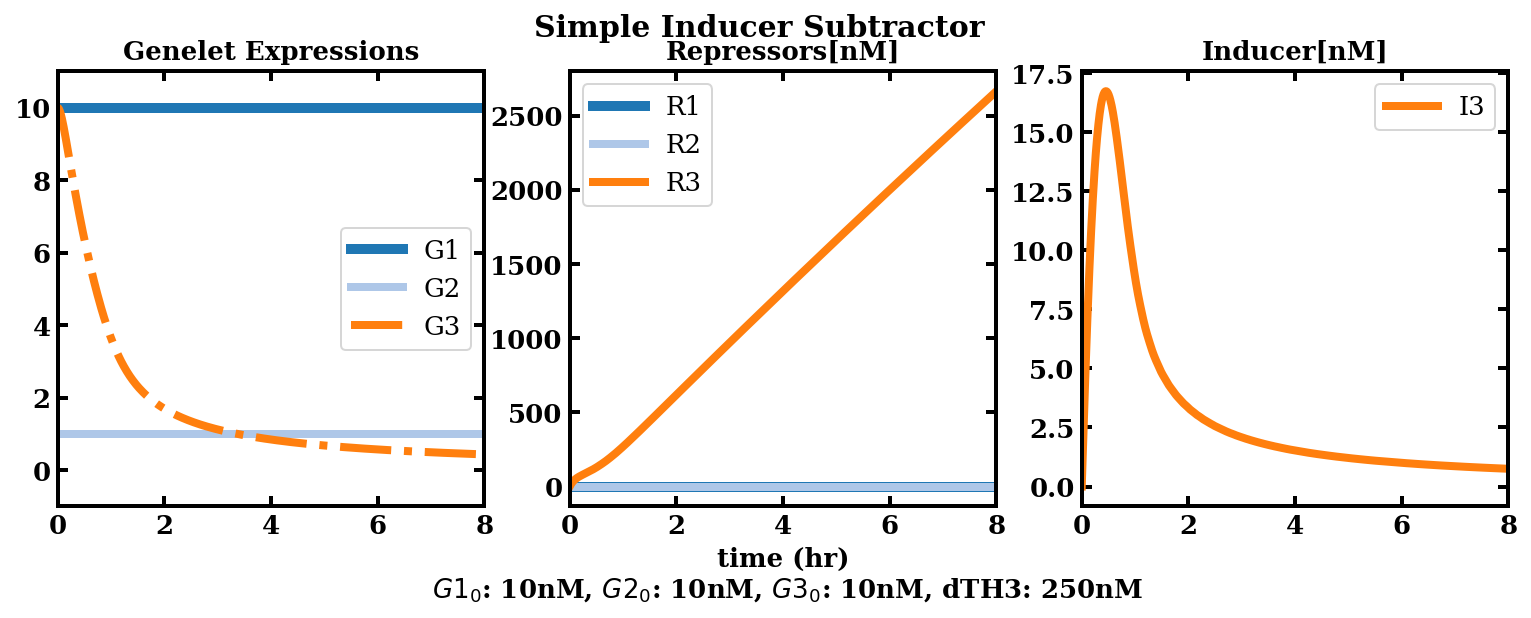

In [79]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0, 250]) # anchored repressor threshold
#                  G1  G2  G3
G_tot = np.array([ 10,  1, 10]) # total genelet added

# initial genelet states
# (0 = OFF, 1 = ON), OFF here is GrR for STG genelets
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

# default of 0 for all other initial conditions
SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 

# Simulation time, unit: seconds
t_vec1 = np.linspace(0, 8, 1001) * 3600 

# Use RNase A for ssRNA degradation
SIS.simulate(t_vec1, 1, rnase = 'both')


# pulling out solutions for plotting from output_concentration attribute
G1 = SIS.output_concentration('Gon1')
G2 = SIS.output_concentration('Gon2')
G3 = SIS.output_concentration('Gon3')


R1 = SIS.output_concentration('rR1')
R2 = SIS.output_concentration('rR2')
R3 = SIS.output_concentration('rR3')

I3 = SIS.output_concentration('rIr3')

sim_t = SIS.sol.t

fig = plt.figure(figsize = (13, 4)); fs = 13;
plt.suptitle('Simple Inducer Subtractor',\
             fontsize = fs + 2, weight = 'bold')
ax1 = plt.subplot(1, 3, 1)
ax1.set_title("Genelet Expressions", fontsize = fs, weight = 'bold')
ax1.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 5, label = "G1")
ax1.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
ax1.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, ls = "-.", label = "G3")
# ax1.set_ylabel('Fraction ON', fontsize = fs, weight = 'bold')
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax1.legend(fontsize = fs)
ax1.set_xlim(0, 8)
ax1.set_ylim(-1, 11)
ax1.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax1.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

ax2 = plt.subplot(1,3,2)
ax2.set_title("Repressors[nM]", fontsize = fs, weight = 'bold')
ax2.plot(sim_t / 3600, R1, color = cm.colors[0], lw = 5, label = "R1")
ax2.plot(sim_t / 3600, R2, color = cm.colors[1], lw = 4, label = "R2")
ax2.plot(sim_t / 3600, R3, color = cm.colors[2], lw = 4, label = "R3")
ax2.set_xlabel('time (hr)\n $G1_0$: 10nM, $G2_0$: 10nM, $G3_0$: 10nM, dTH3: 250nM',\
               fontsize = fs, weight = 'bold')
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax2.legend(fontsize = fs)
ax2.set_xlim(0, 8)
ax2.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax2.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')
# plt.axis('equal')

ax3 = plt.subplot(1,3,3)
ax3.set_title("Inducer[nM]",fontsize = fs, weight = 'bold')
ax3.plot(sim_t / 3600, I3, color = cm.colors[2], lw = 4, label = "I3")
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax3.legend(fontsize = fs)
ax3.set_xlim(0, 8)
ax3.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax3.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')
# plt.axis('equal')

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

### Network 1, Simple Inducer Subtractor
- 4 case simulation
- Works only if there is thresholding strands
- thresholding strand of 250 or 500 for G3
        rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
        rprd_vec = [-3, 0, 0] # genelets producing repressors
        iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...
        SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')
        Thresh_tot = np.array([  0,   0, 250]) # anchored repressor threshold
        (g1, g2) = (1 for lo, 10 for hi)
        G_tot = np.array([g1, g2, 10])

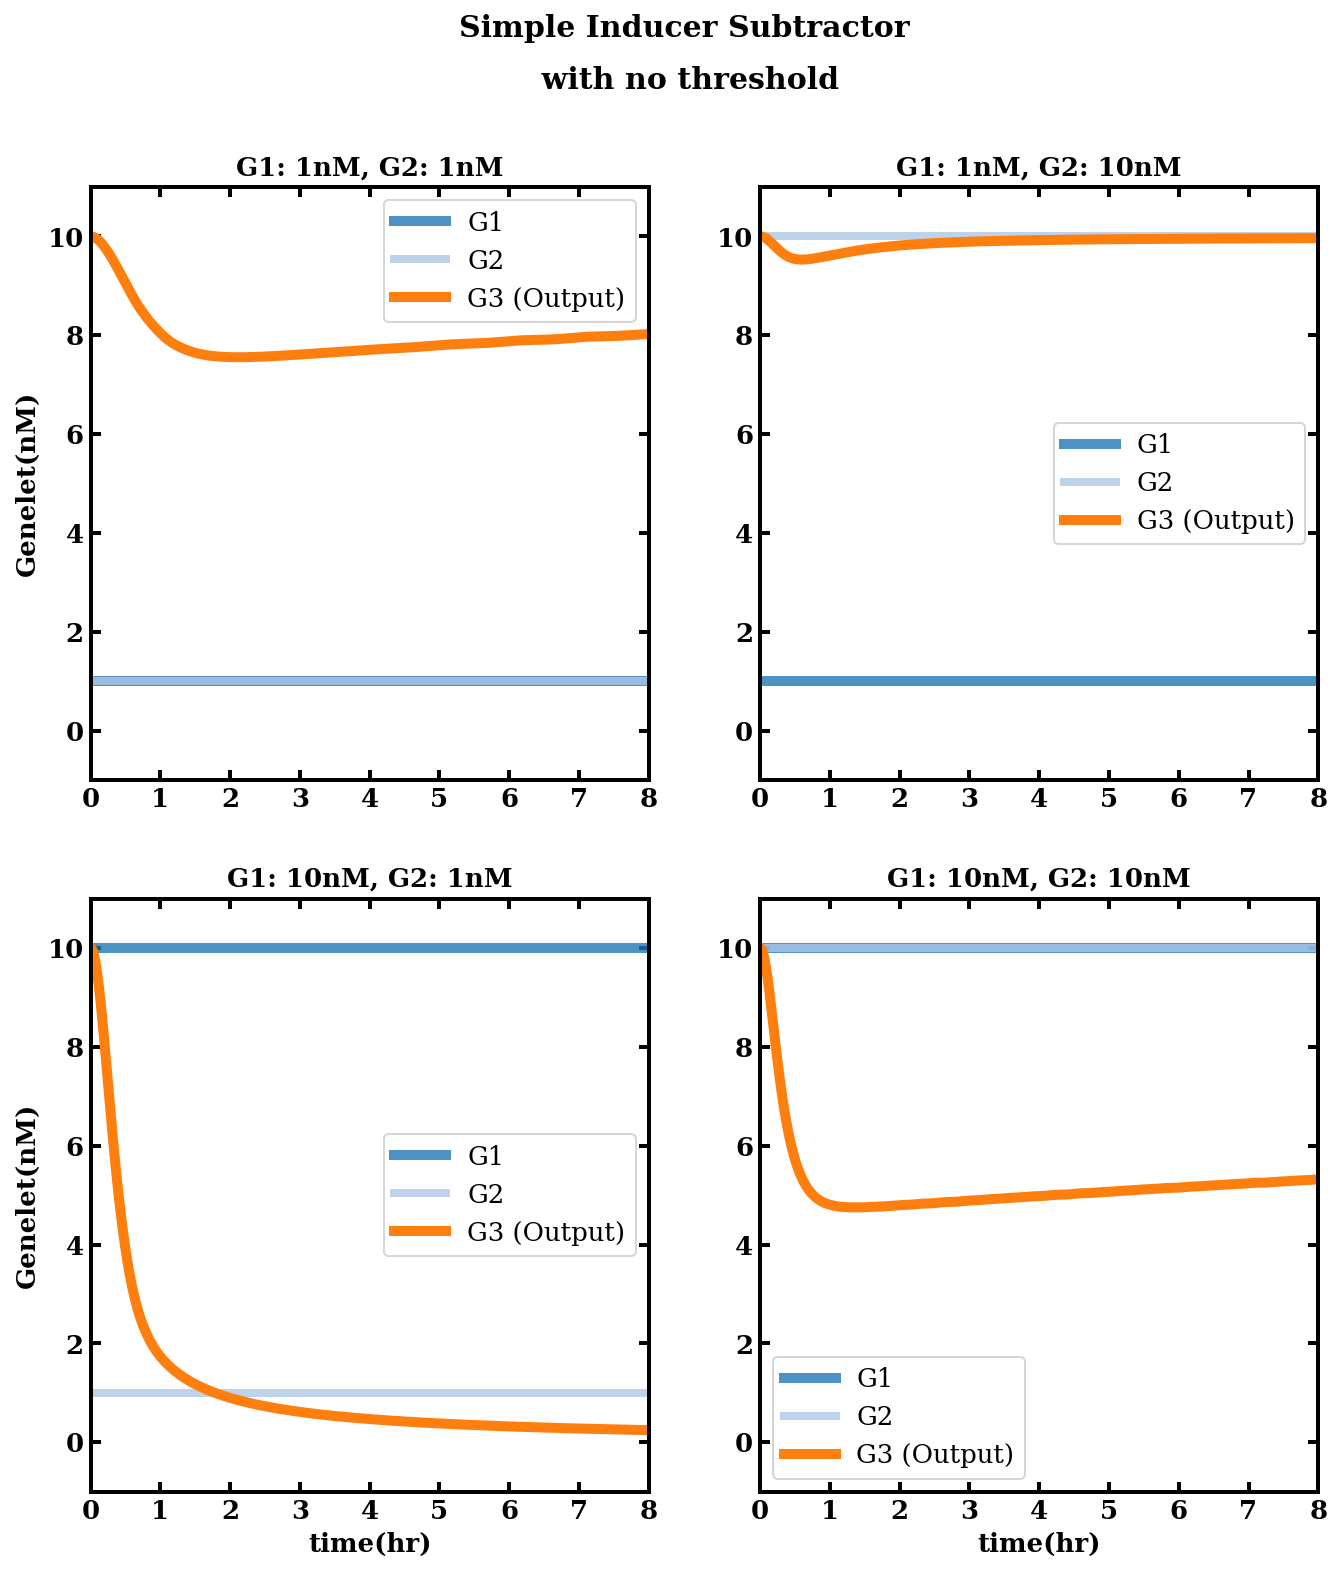

In [54]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0,  0]) # anchored repressor threshold
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

fig = plt.figure(figsize = (11, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Inducer Subtractor\n with no threshold',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 8, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SIS.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = SIS.output_concentration('Gon1')
        G2 = SIS.output_concentration('Gon2')
        G3 = SIS.output_concentration('Gon3')
        sim_t = SIS.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 5, label = "G1", alpha = .8)
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2", alpha = .8)
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 5, label = "G3 (Output)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 8)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

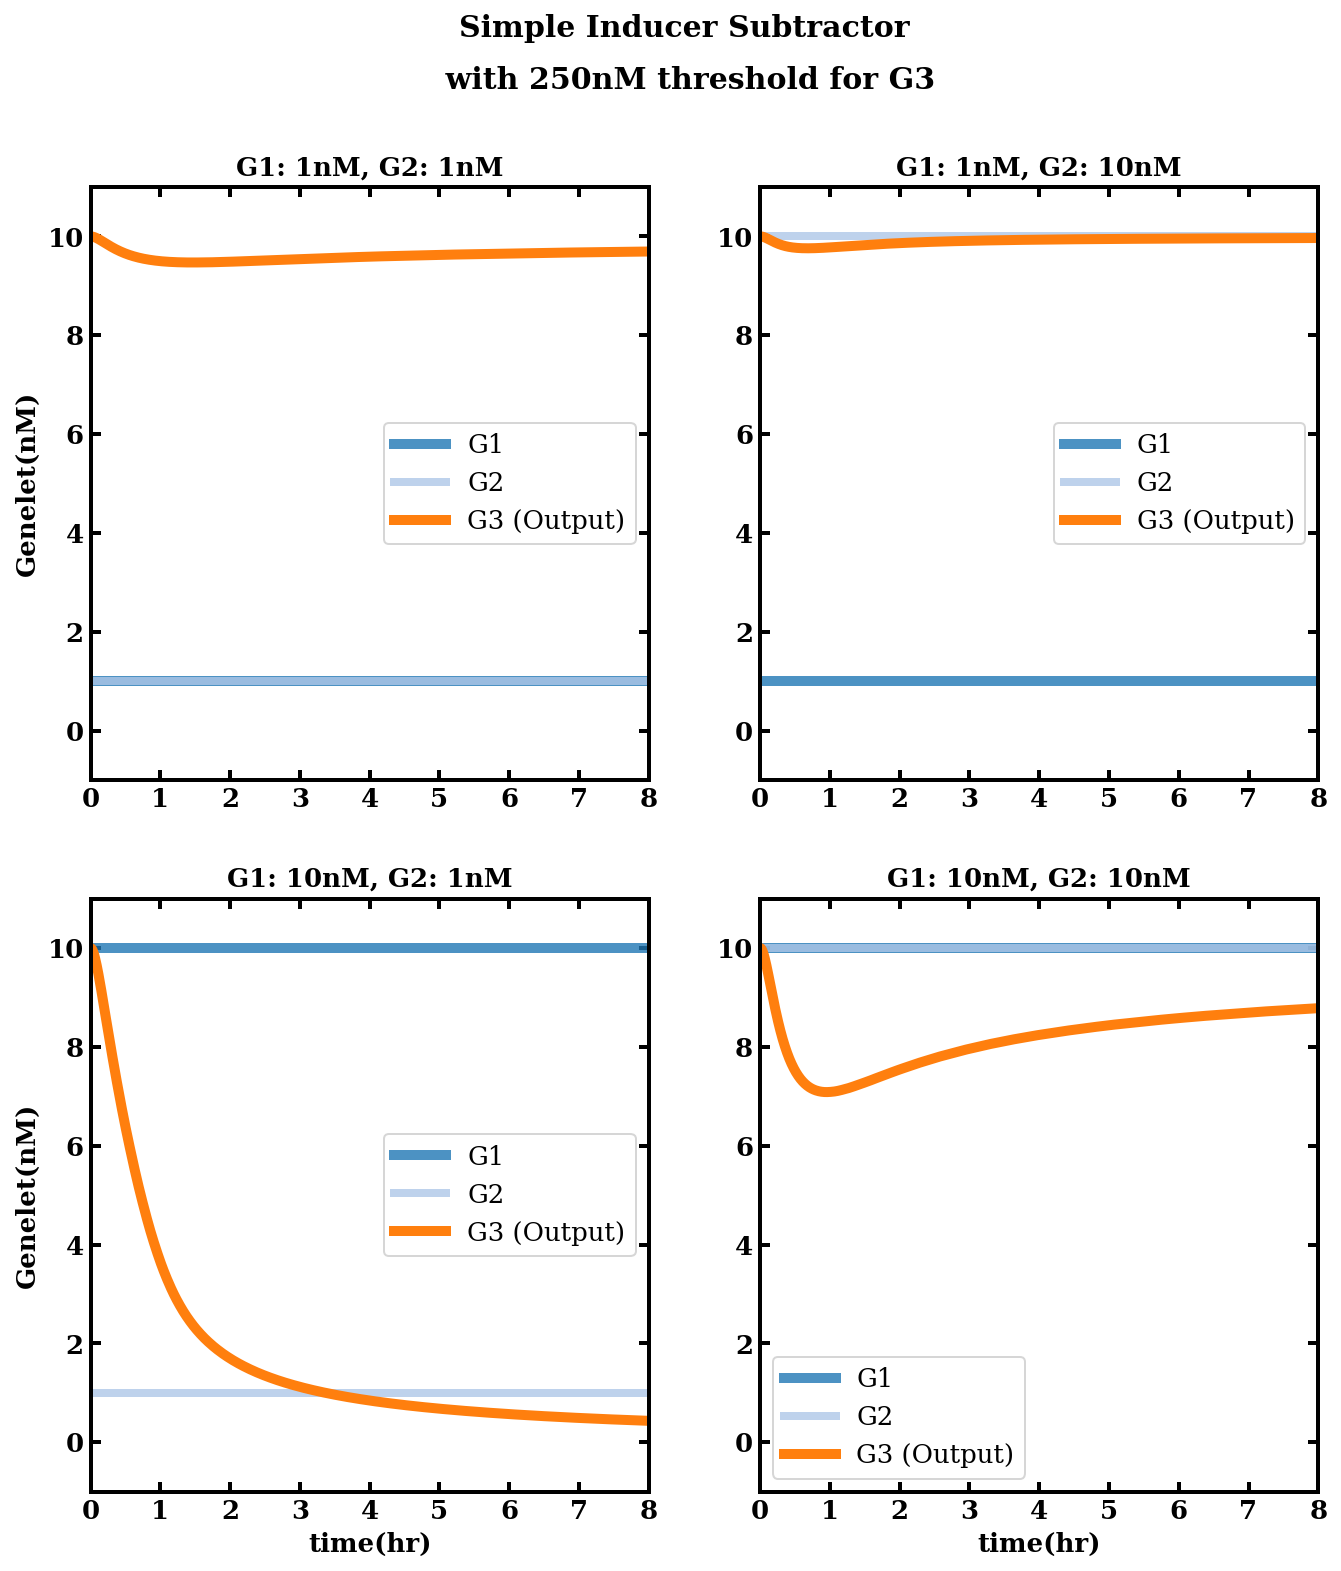

In [62]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0, 250]) # anchored repressor threshold
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

fig = plt.figure(figsize = (11, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Inducer Subtractor\n with 250nM threshold for G3',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 8, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SIS.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = SIS.output_concentration('Gon1')
        G2 = SIS.output_concentration('Gon2')
        G3 = SIS.output_concentration('Gon3')
        sim_t = SIS.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 5, label = "G1", alpha = .8)
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2", alpha = .8)
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 5, label = "G3 (Output)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 8)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

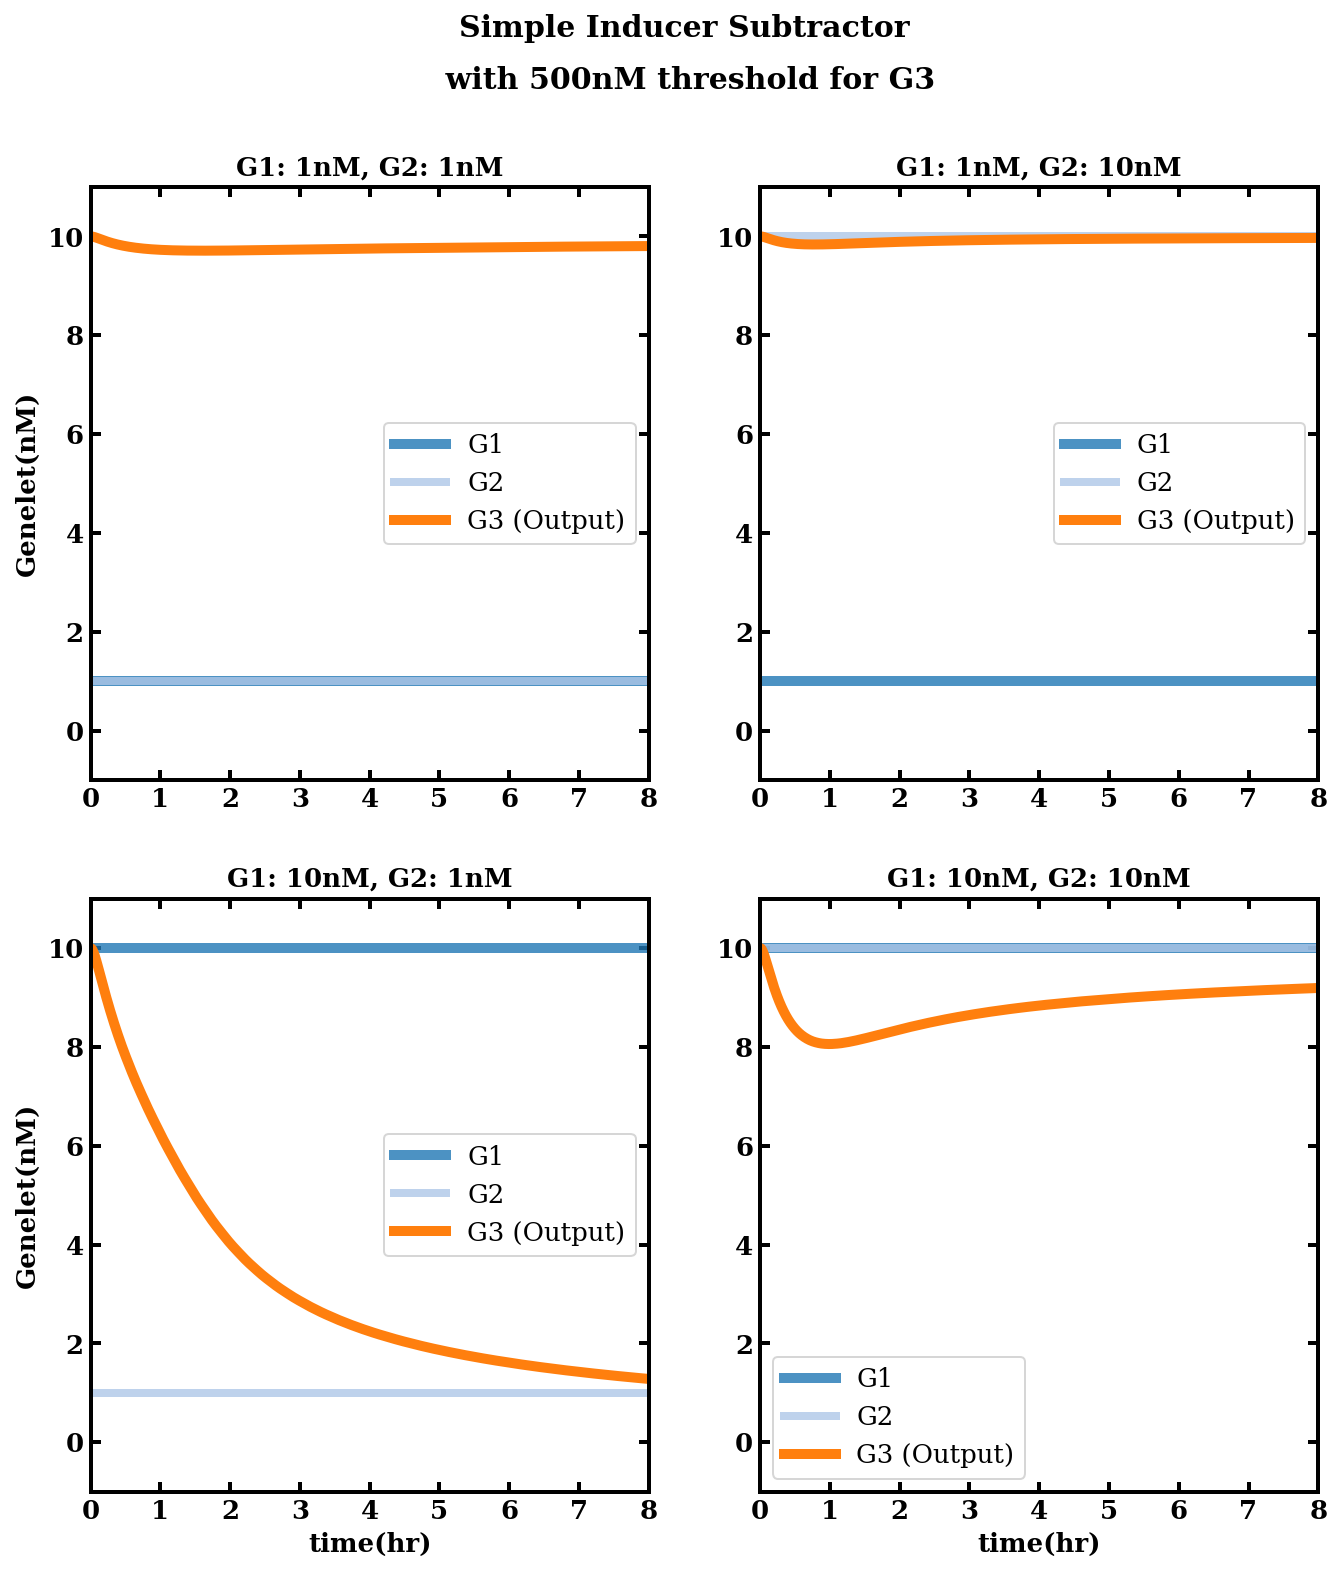

In [55]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0, 500]) # anchored repressor threshold
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

fig = plt.figure(figsize = (11, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Inducer Subtractor\n with 500nM threshold for G3',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 8, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SIS.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = SIS.output_concentration('Gon1')
        G2 = SIS.output_concentration('Gon2')
        G3 = SIS.output_concentration('Gon3')
        sim_t = SIS.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 5, label = "G1", alpha = .8)
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2", alpha = .8)
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 5, label = "G3 (Output)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 8)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

### Network 1, Simple Inducer Subtractor
- Sensitivity Matrix

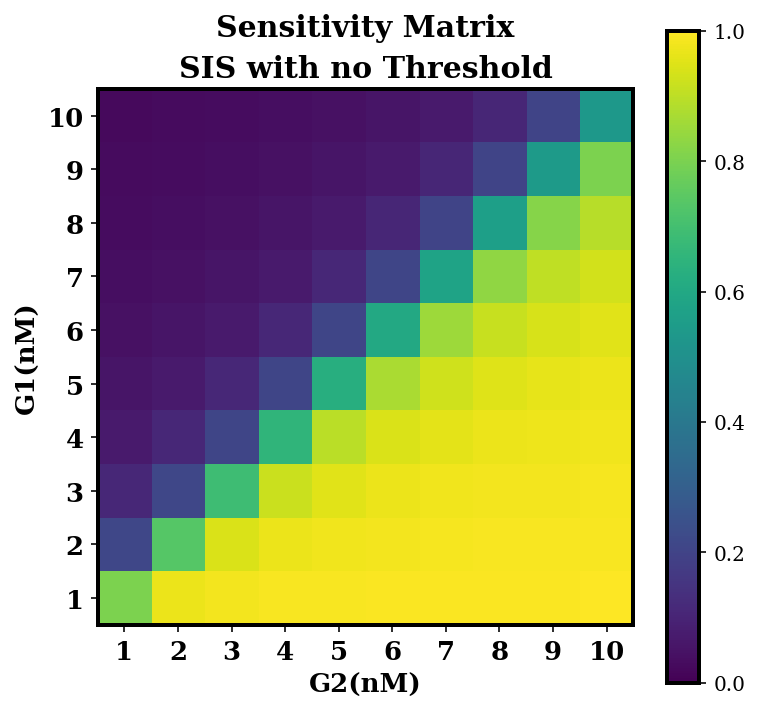

In [82]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0, 0]) # anchored repressor threshold
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 8, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SIS.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SIS.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSIS with no Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

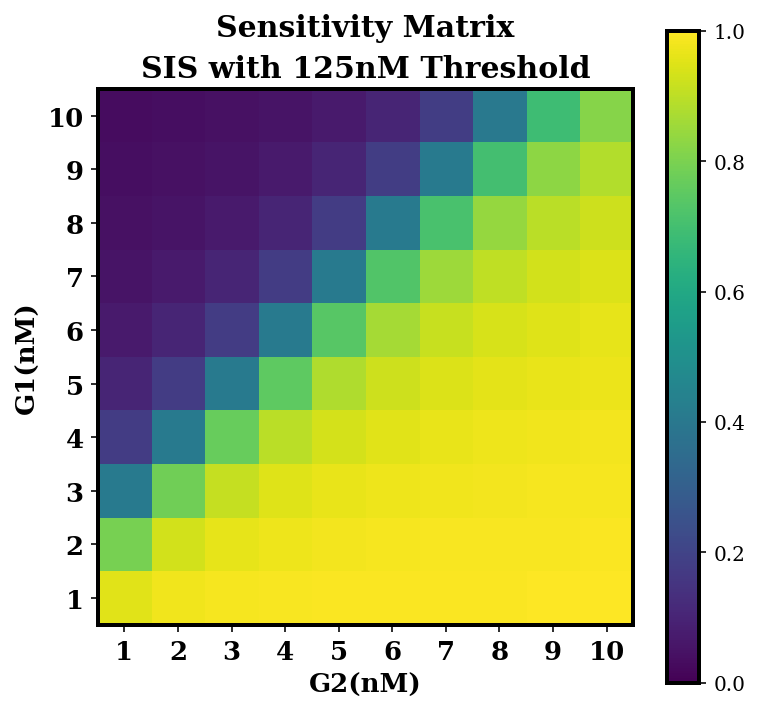

In [85]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0, 125]) # anchored repressor threshold
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 8, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SIS.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SIS.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSIS with 125nM Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

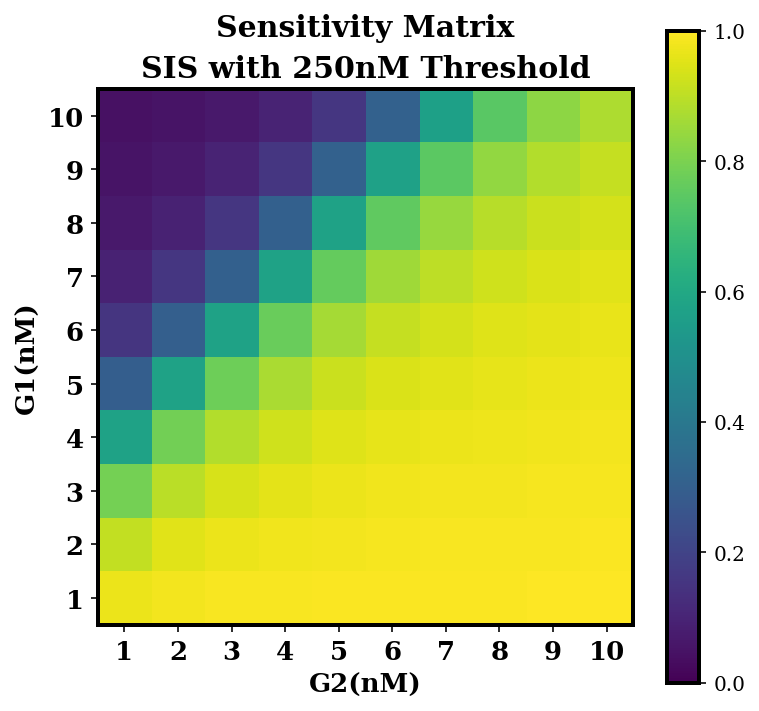

In [86]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3, 0, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0,-3, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2  dA3
Thresh_tot = np.array([  0,   0, 250]) # anchored repressor threshold
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SIS.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 8, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SIS.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SIS.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSIS with 250nM Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

## Activation with double repression

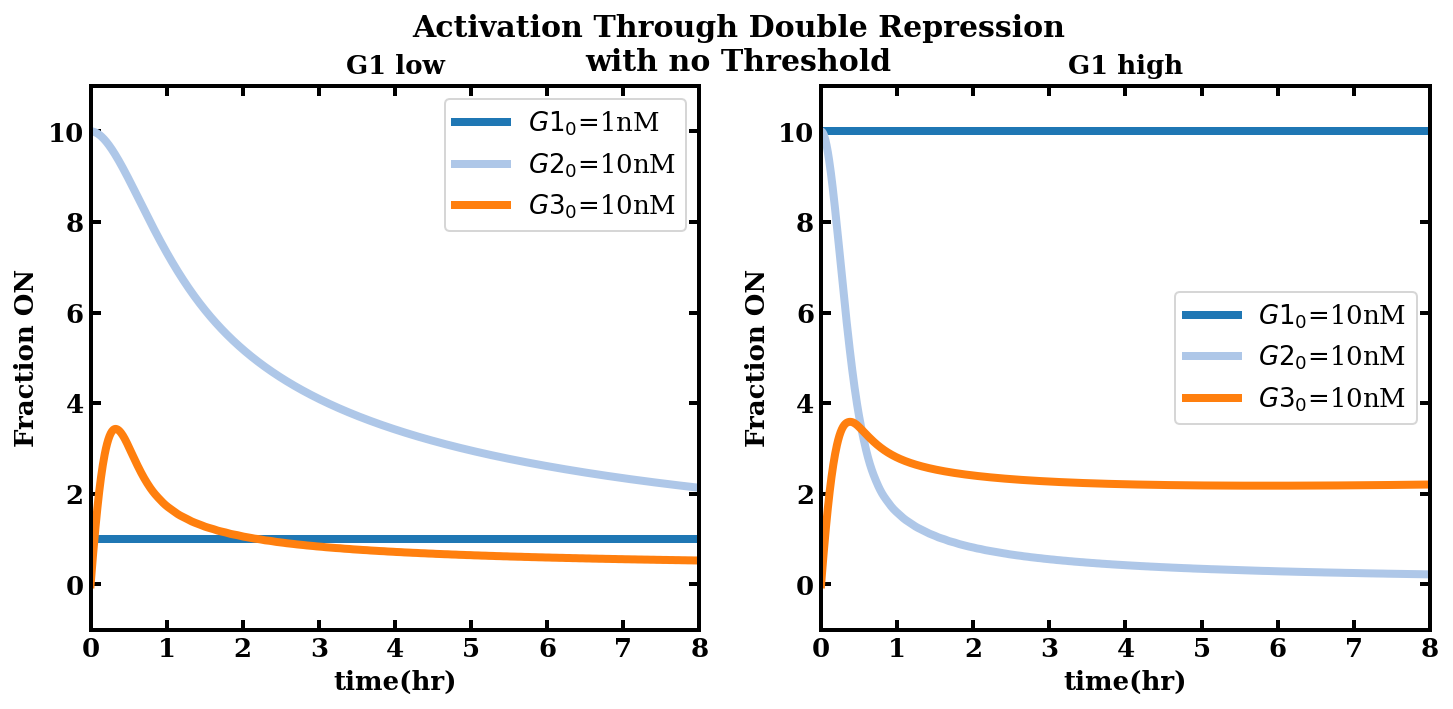

In [75]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                         dA1  dA2  dA3
RepThresh_tot = np.array([0, 0, 0]) * 1 # total repressor threshold added
#            G1 G2 G3
G_int_vec = [ 1, 1, 0]

fig = plt.figure(figsize = (12, 5)); fs = 13; ctr = 1;
ax = plt.subplot(1, 2, 1)
#                 G1  G2  G3
G_tot = np.array([ 1, 10, 10]) # total genelet added
# default of 0 for all other initial conditions
SIS.initial_conditions(RepThresh_tot, G_tot, G_int_vec) 
# Simulation time, unit: seconds
t_vec1 = np.linspace(0, 8, 1001) * 3600 
# Use RNase A for ssRNA degradation
SIS.simulate(t_vec1, 1, rnase = 'both')
# pulling out solutions for plotting from output_concentration attribute
G1 = SIS.output_concentration('Gon1')
G2 = SIS.output_concentration('Gon2')
G3 = SIS.output_concentration('Gon3')
sim_t = SIS.sol.t
ax.set_title("G1 low", fontsize = fs, weight = 'bold')
ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "$G1_0$=1nM")
ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "$G2_0$=10nM")
ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "$G3_0$=10nM")
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax.set_ylabel('Fraction ON', fontsize = fs, weight = 'bold')
ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
ax.legend(fontsize = fs)
ax.set_xlim(0, 8)
ax.set_ylim(-1, 11)
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

ax = plt.subplot(1, 2, 2)
#                 G1  G2  G3
G_tot = np.array([ 10, 10, 10]) # total genelet added
# default of 0 for all other initial conditions
SIS.initial_conditions(RepThresh_tot, G_tot, G_int_vec) 
# Simulation time, unit: seconds
t_vec1 = np.linspace(0, 8, 1001) * 3600 
# Use RNase A for ssRNA degradation
SIS.simulate(t_vec1, 1, rnase = 'both')
# pulling out solutions for plotting from output_concentration attribute
G1 = SIS.output_concentration('Gon1')
G2 = SIS.output_concentration('Gon2')
G3 = SIS.output_concentration('Gon3')
sim_t = SIS.sol.t
ax.set_title("G1 high", fontsize = fs, weight = 'bold')
ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "$G1_0$=10nM")
ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "$G2_0$=10nM")
ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "$G3_0$=10nM")
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax.set_ylabel('Fraction ON', fontsize = fs, weight = 'bold')
ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
ax.legend(fontsize = fs)
ax.set_xlim(0, 8)
ax.set_ylim(-1, 11)
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')
fig.suptitle("Activation Through Double Repression\nwith no Threshold", fontsize = fs + 2, weight = 'bold');

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

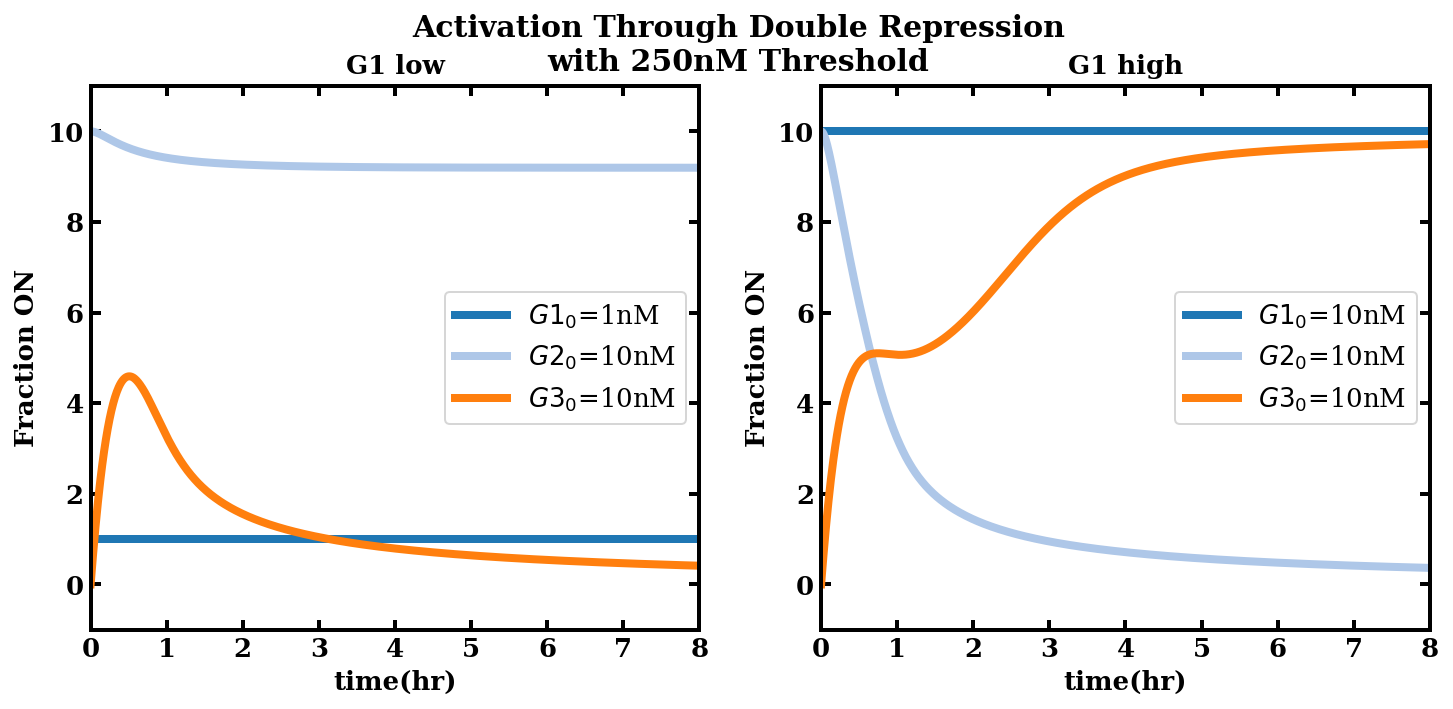

In [74]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SIS = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                         dA1  dA2  dA3
RepThresh_tot = np.array([250, 250, 250]) * 1 # total repressor threshold added
#            G1 G2 G3
G_int_vec = [ 1, 1, 0]

fig = plt.figure(figsize = (12, 5)); fs = 13; ctr = 1;
ax = plt.subplot(1, 2, 1)
#                 G1  G2  G3
G_tot = np.array([ 1, 10, 10]) # total genelet added
# default of 0 for all other initial conditions
SIS.initial_conditions(RepThresh_tot, G_tot, G_int_vec) 
# Simulation time, unit: seconds
t_vec1 = np.linspace(0, 8, 1001) * 3600 
# Use RNase A for ssRNA degradation
SIS.simulate(t_vec1, 1, rnase = 'both')
# pulling out solutions for plotting from output_concentration attribute
G1 = SIS.output_concentration('Gon1')
G2 = SIS.output_concentration('Gon2')
G3 = SIS.output_concentration('Gon3')
sim_t = SIS.sol.t
ax.set_title("G1 low", fontsize = fs, weight = 'bold')
ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "$G1_0$=1nM")
ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "$G2_0$=10nM")
ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "$G3_0$=10nM")
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax.set_ylabel('Fraction ON', fontsize = fs, weight = 'bold')
ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
ax.legend(fontsize = fs)
ax.set_xlim(0, 8)
ax.set_ylim(-1, 11)
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

ax = plt.subplot(1, 2, 2)
#                 G1  G2  G3
G_tot = np.array([ 10, 10, 10]) # total genelet added
# default of 0 for all other initial conditions
SIS.initial_conditions(RepThresh_tot, G_tot, G_int_vec) 
# Simulation time, unit: seconds
t_vec1 = np.linspace(0, 8, 1001) * 3600 
# Use RNase A for ssRNA degradation
SIS.simulate(t_vec1, 1, rnase = 'both')
# pulling out solutions for plotting from output_concentration attribute
G1 = SIS.output_concentration('Gon1')
G2 = SIS.output_concentration('Gon2')
G3 = SIS.output_concentration('Gon3')
sim_t = SIS.sol.t
ax.set_title("G1 high", fontsize = fs, weight = 'bold')
ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "$G1_0$=10nM")
ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "$G2_0$=10nM")
ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "$G3_0$=10nM")
plt.xticks(fontsize = fs, weight = 'bold')
plt.yticks(fontsize = fs, weight = 'bold')
ax.set_ylabel('Fraction ON', fontsize = fs, weight = 'bold')
ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
ax.legend(fontsize = fs)
ax.set_xlim(0, 8)
ax.set_ylim(-1, 11)
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')
fig.suptitle("Activation Through Double Repression\nwith 250nM Threshold", fontsize = fs + 2, weight = 'bold');

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

## Simple Bistable Comparator

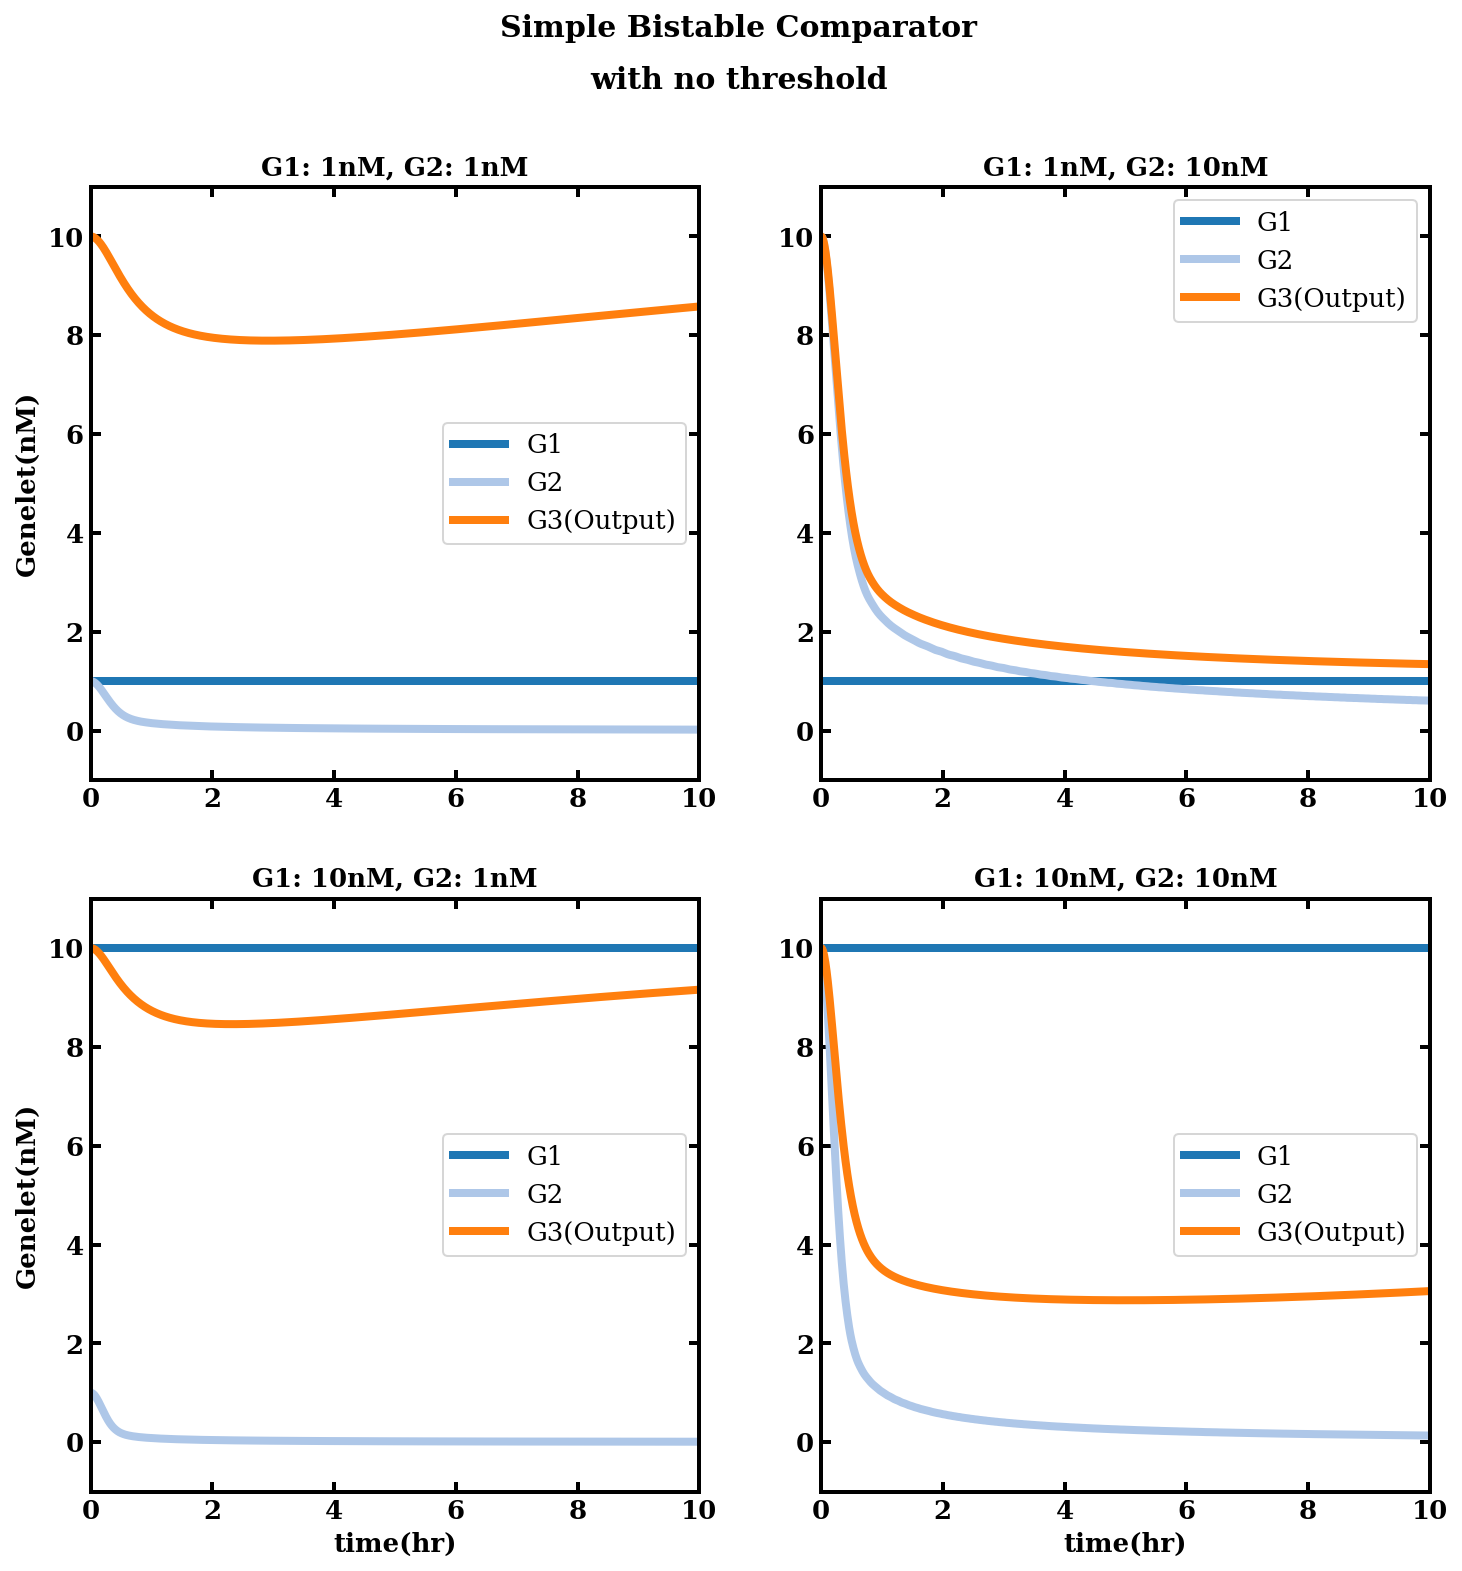

In [121]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([  0,   0,   0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Bistable Comparator\nwith no threshold',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = SBSC.output_concentration('Gon1')
        G2 = SBSC.output_concentration('Gon2')
        G3 = SBSC.output_concentration('Gon3')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3(Output)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

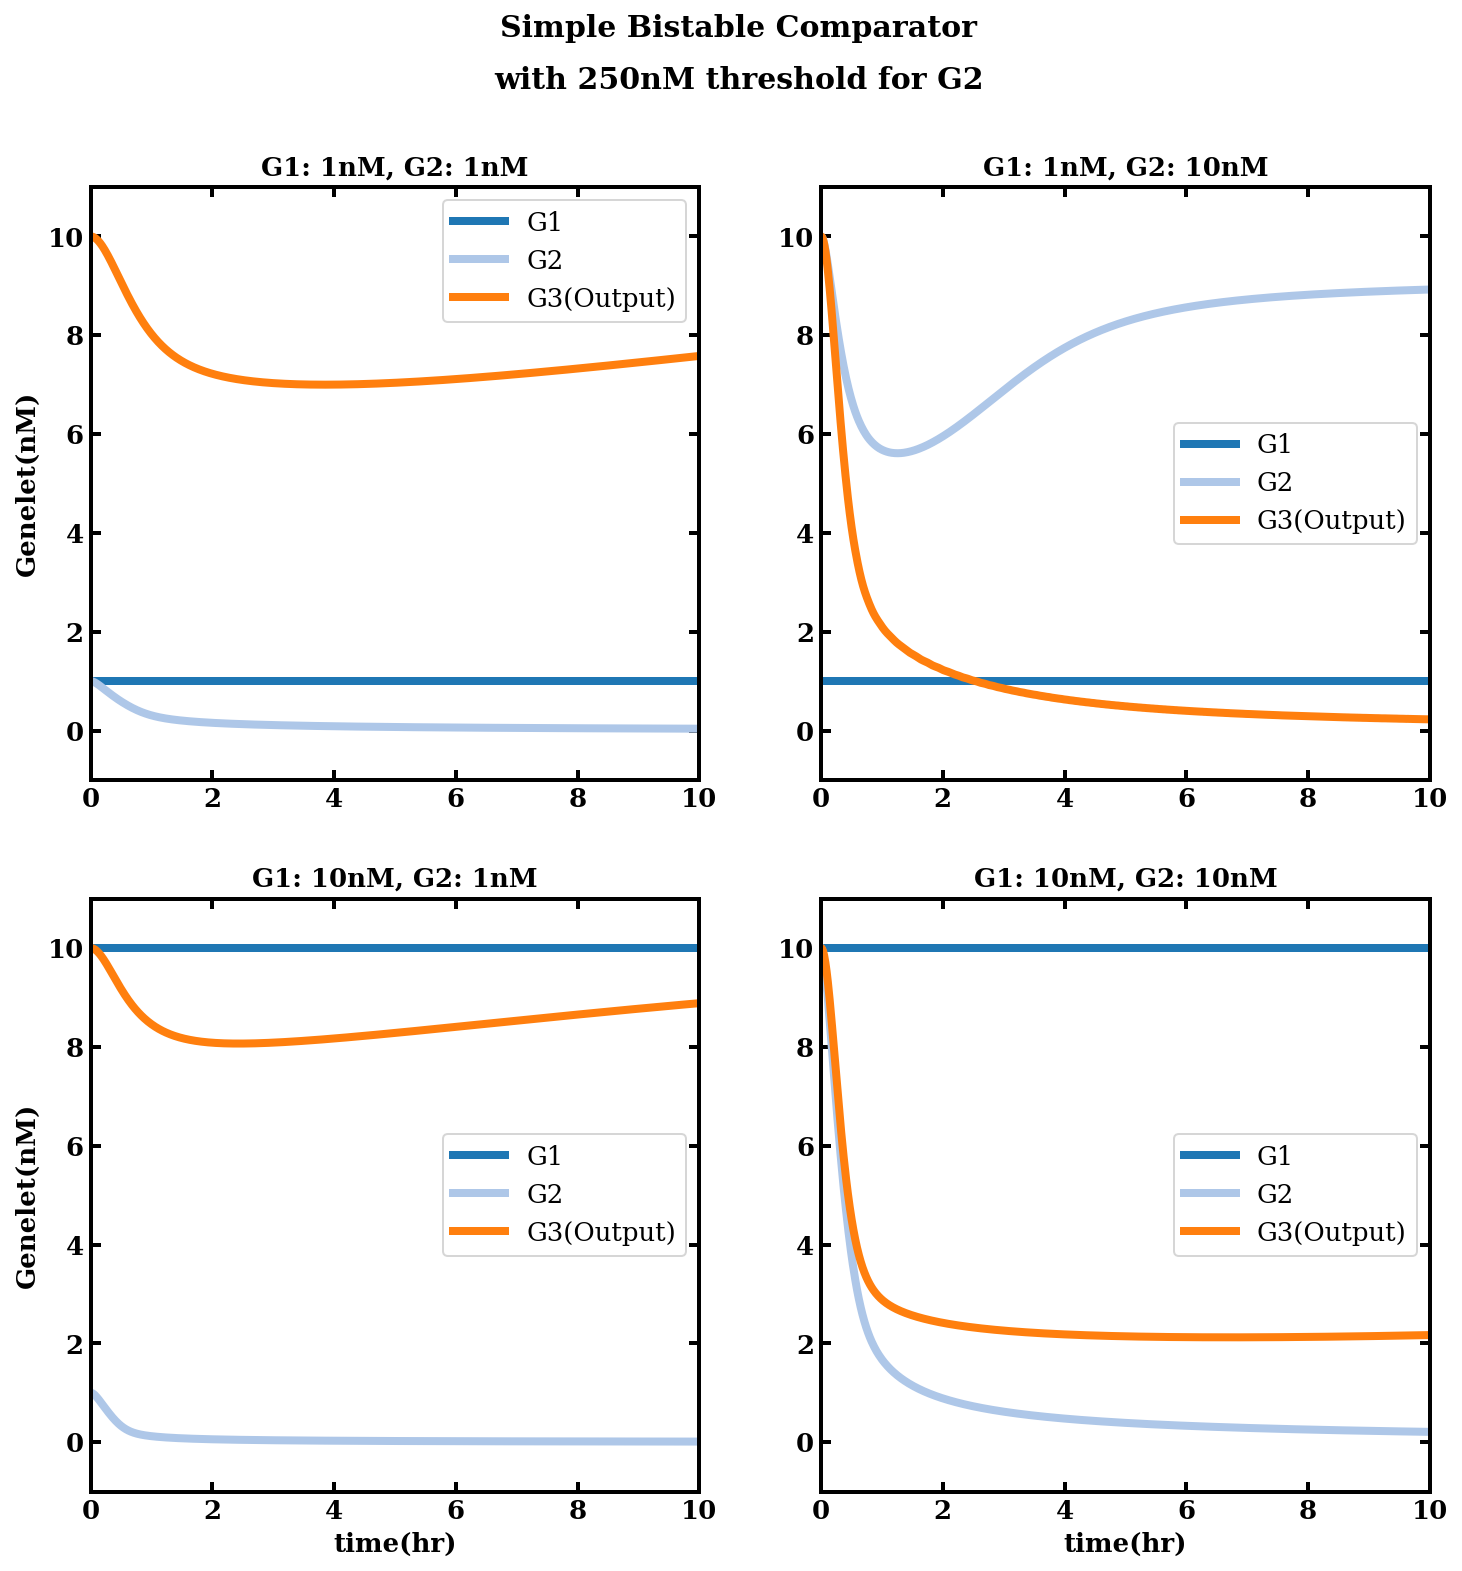

In [131]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([ 0, 250, 0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Bistable Comparator\nwith 250nM threshold for G2',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = SBSC.output_concentration('Gon1')
        G2 = SBSC.output_concentration('Gon2')
        G3 = SBSC.output_concentration('Gon3')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3(Output)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

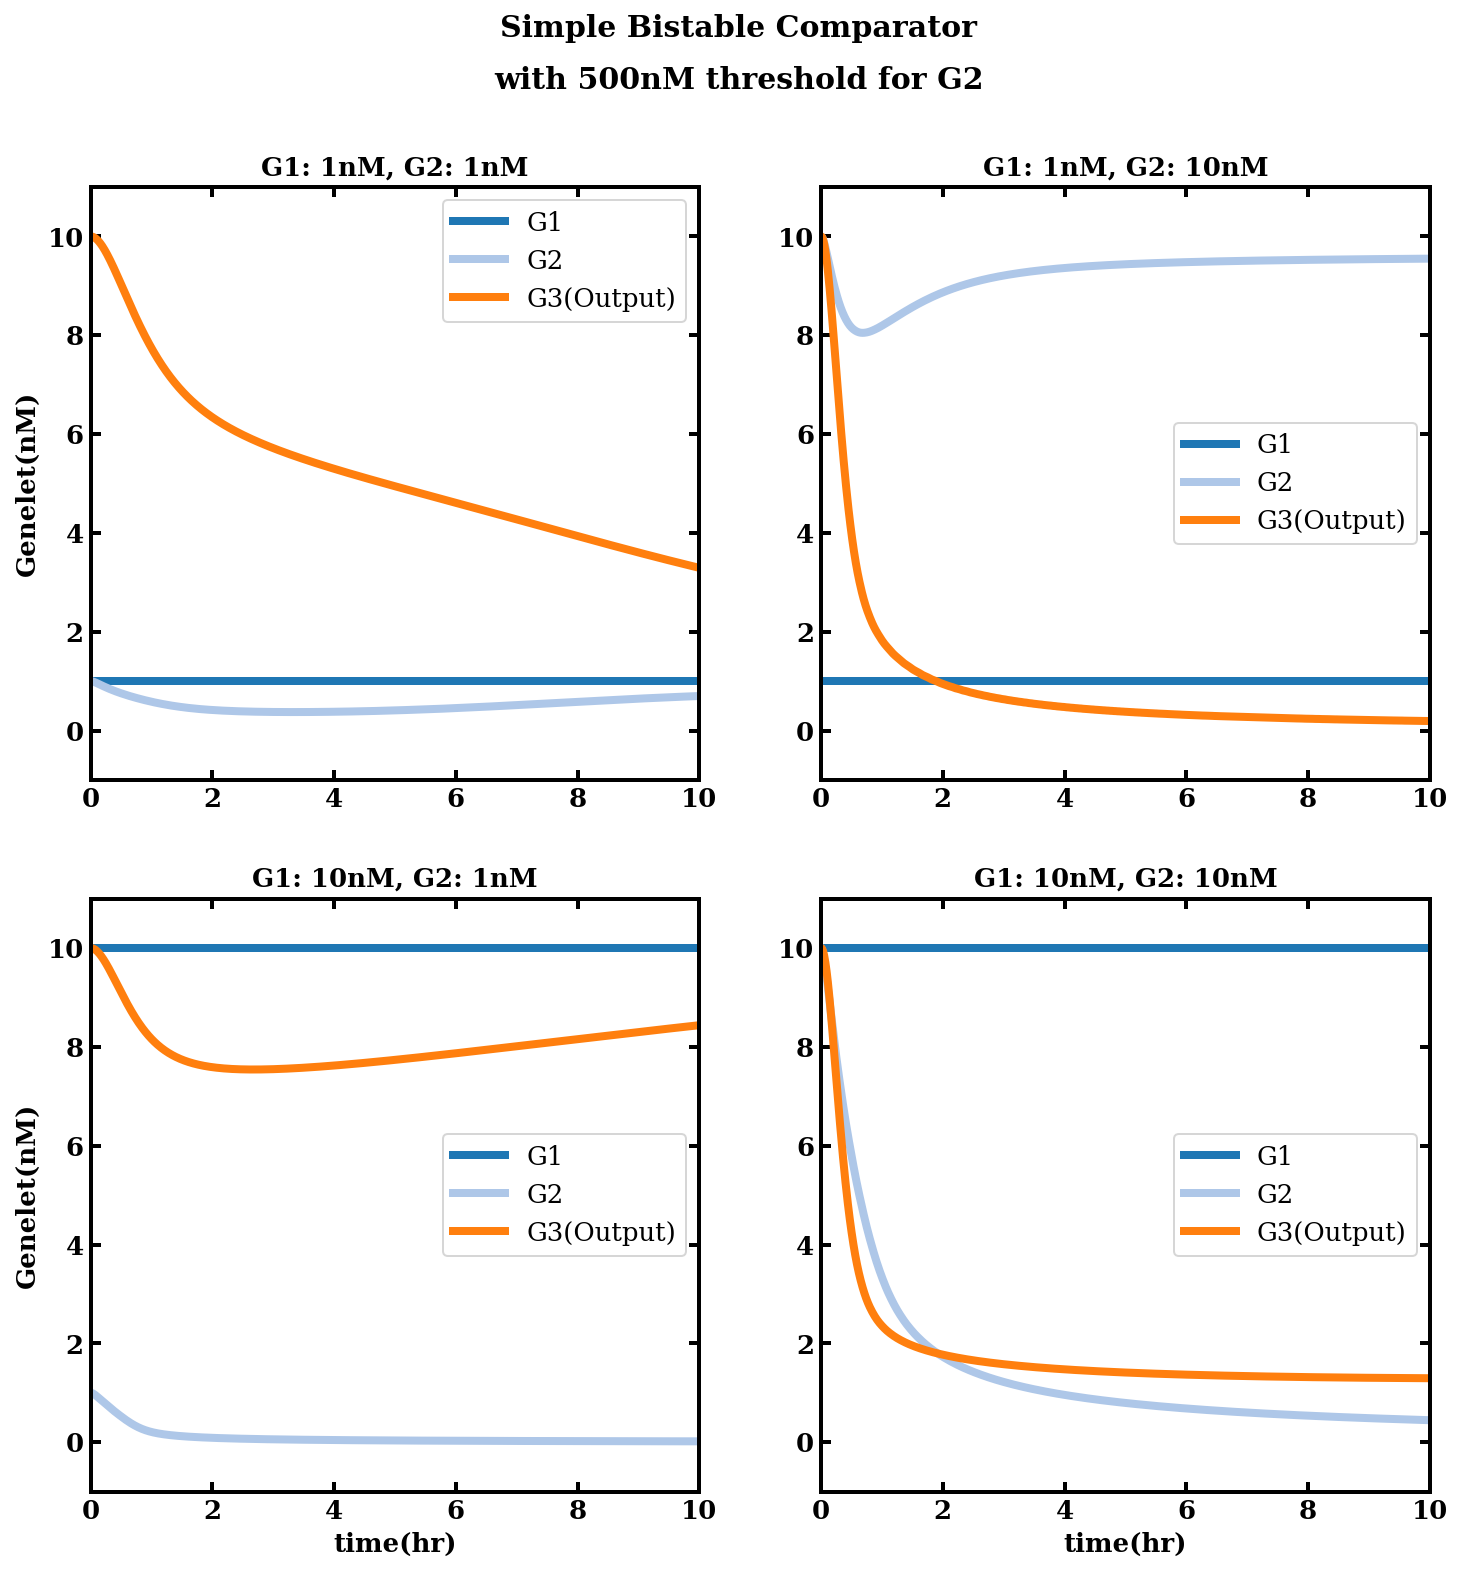

In [129]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([ 0, 500,  0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Bistable Comparator\nwith 500nM threshold for G2',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = SBSC.output_concentration('Gon1')
        G2 = SBSC.output_concentration('Gon2')
        G3 = SBSC.output_concentration('Gon3')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3(Output)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

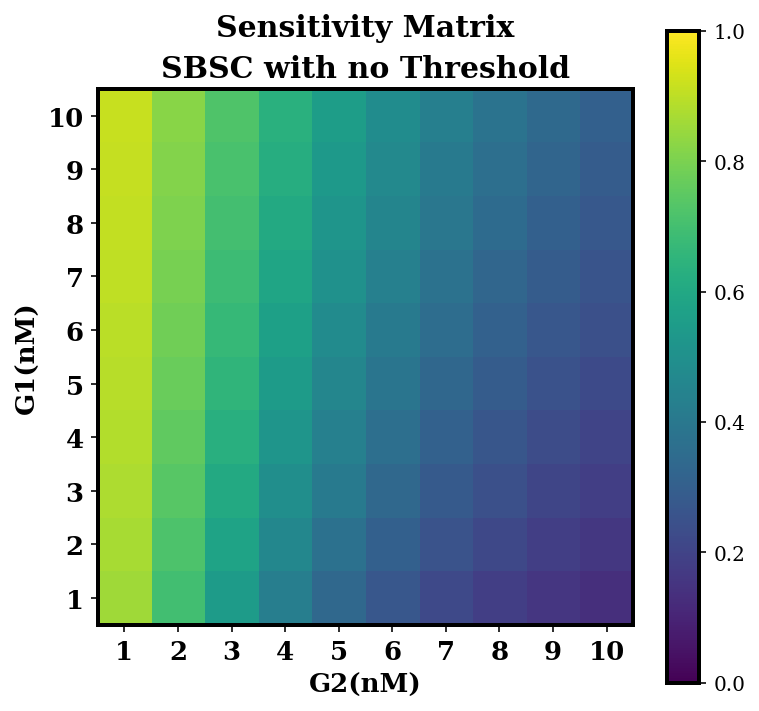

In [137]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([ 0, 0,  0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SBSC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSBSC with no Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

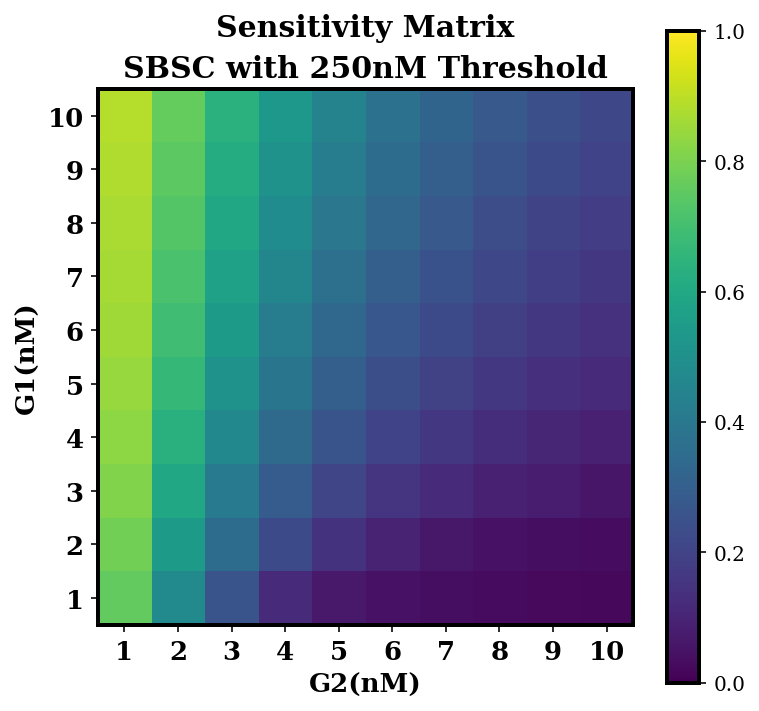

In [139]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([ 0, 250,  0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SBSC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSBSC with 250nM Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

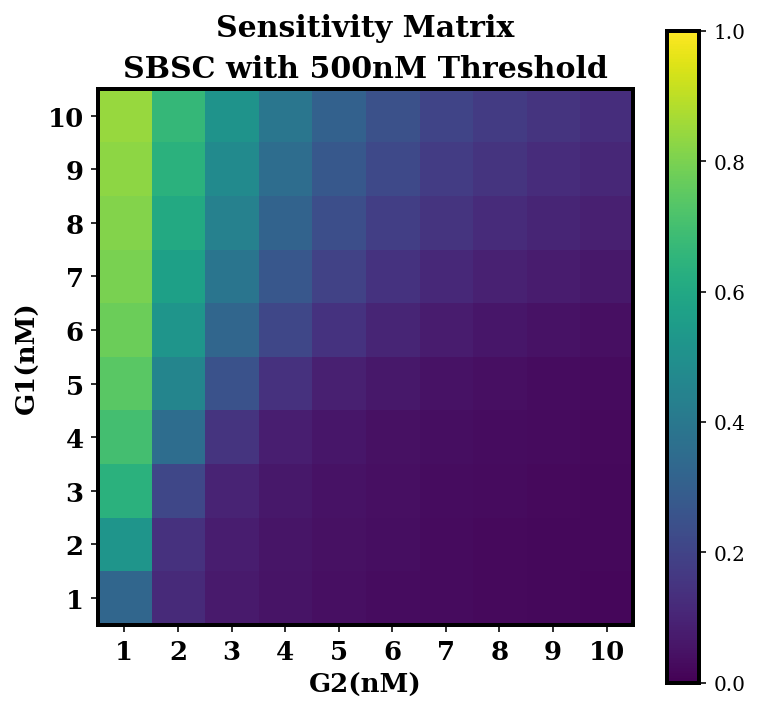

In [136]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([ 0, 500,  0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SBSC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSBSC with 500nM Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

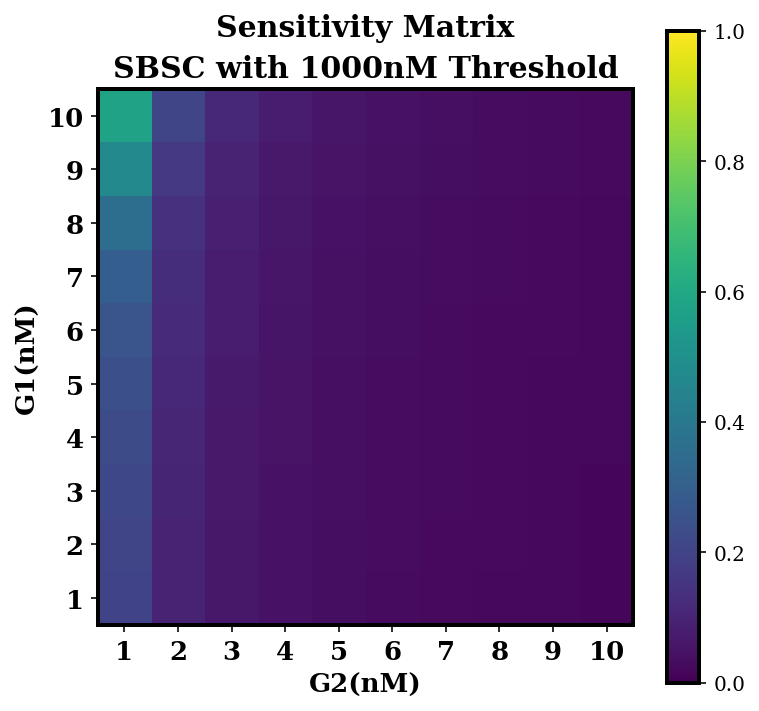

In [140]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3
#         Rs
rep_vec =  [ 1, 2, 3] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-3,-2] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
SBSC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1  dA2 dA3
Thresh_tot = np.array([ 0, 1000,  0]) # total activator added
#            G1 G2 G3
G_int_vec = [ 1, 1, 1]


snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3
        G_tot = np.array([g1, g2, 10]) # total genelet added
        # default of 0 for all other initial conditions
        SBSC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        SBSC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = SBSC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nSBSC with 1000nM Threshold",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

## Bistable Inducer Circuit

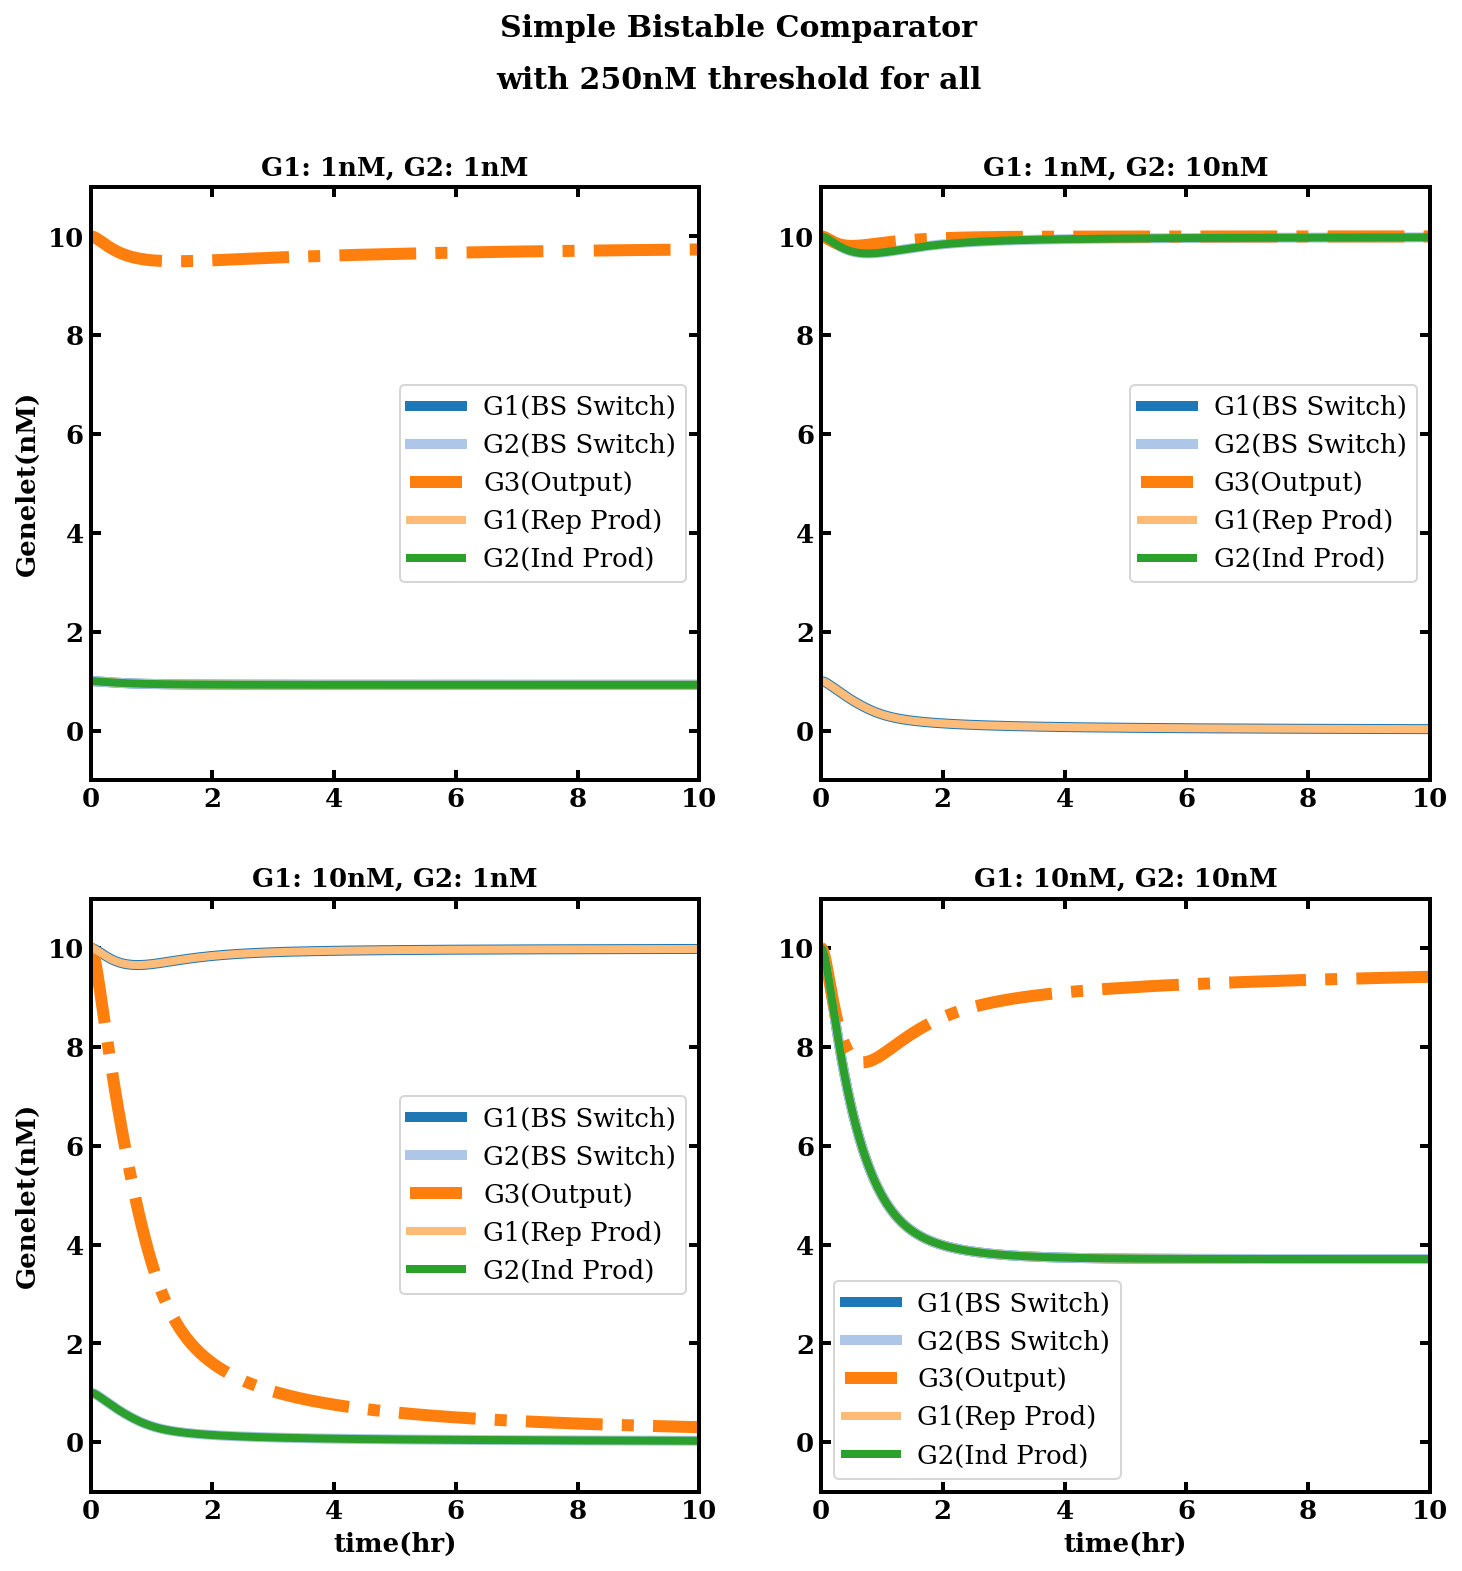

In [146]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5
#         Rs
rep_vec =  [ 1, 2, 3, 1, 2] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-1, 0,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0,-3] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
BIC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3
Thresh_tot = np.array([250,250,250]) # total activator added
#            G1 G2 G3 G4 G5
G_int_vec = [ 1, 1, 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('Simple Bistable Comparator\nwith 250nM threshold for all',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3  G4  G5
        G_tot = np.array([g1, g2, 10, g1, g2]) # total genelet added
        # default of 0 for all other initial conditions
        BIC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        BIC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = BIC.output_concentration('Gon1')
        G2 = BIC.output_concentration('Gon2')
        G3 = BIC.output_concentration('Gon3')
        G4 = BIC.output_concentration('Gon4')
        G5 = BIC.output_concentration('Gon5')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 5, label = "G1(BS Switch)")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 5, label = "G2(BS Switch)")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 6, ls = "-.", label = "G3(Output)")
        ax.plot(sim_t / 3600, G4, color = cm.colors[3], lw = 4, label = "G1(Rep Prod)")
        ax.plot(sim_t / 3600, G5, color = cm.colors[4], lw = 4, label = "G2(Ind Prod)")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

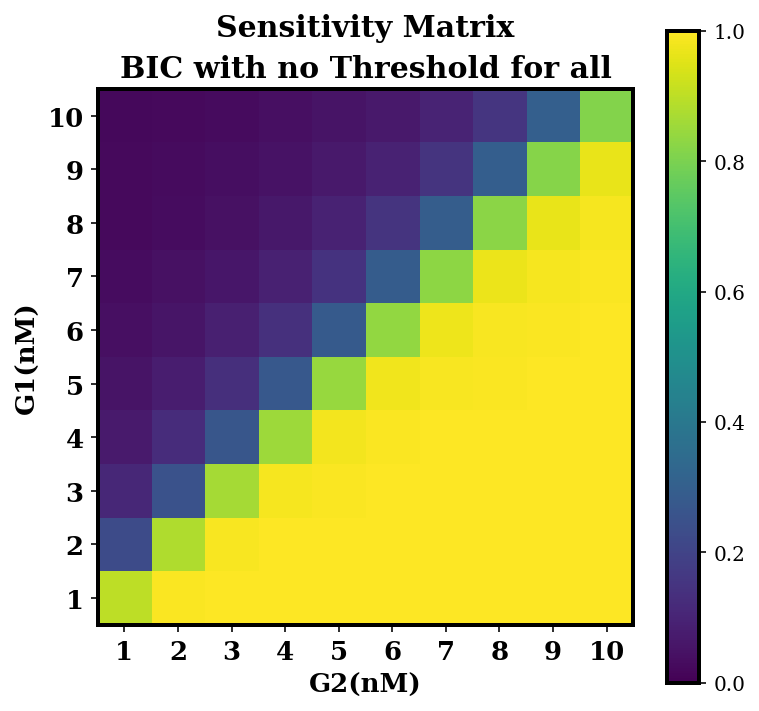

In [151]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5
#         Rs
rep_vec =  [ 1, 2, 3, 1, 2] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-1, 0,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0,-3] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
BIC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3
Thresh_tot = np.array([  0,  0,  0]) # total activator added
#            G1 G2 G3 G4 G5
G_int_vec = [ 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5
        G_tot = np.array([g1, g2, 10, g1, g2]) # total genelet added
        # default of 0 for all other initial conditions
        BIC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        BIC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = BIC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nBIC with no Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

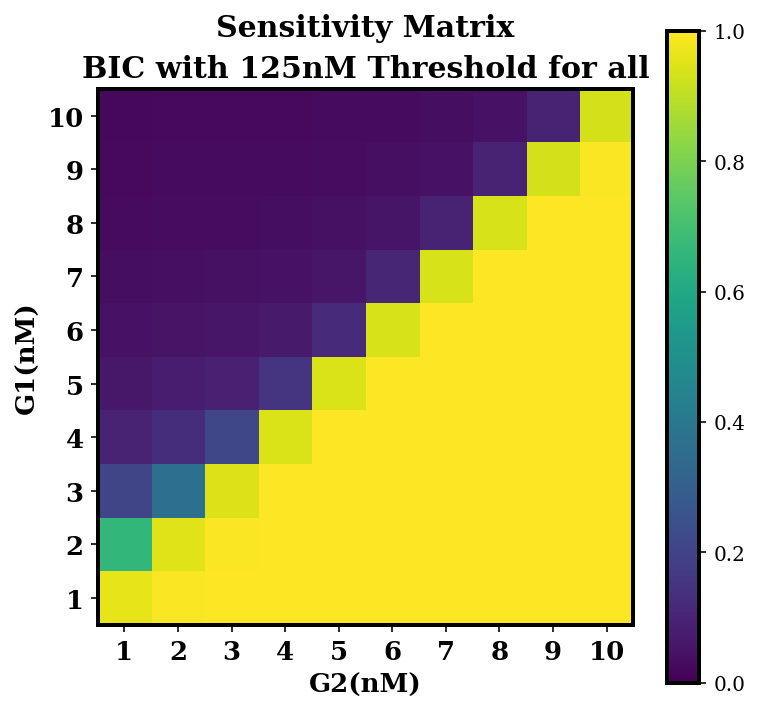

In [150]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5
#         Rs
rep_vec =  [ 1, 2, 3, 1, 2] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-1, 0,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0,-3] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
BIC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3
Thresh_tot = np.array([125,125,125]) # total activator added
#            G1 G2 G3 G4 G5
G_int_vec = [ 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5
        G_tot = np.array([g1, g2, 10, g1, g2]) # total genelet added
        # default of 0 for all other initial conditions
        BIC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        BIC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = BIC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nBIC with 125nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

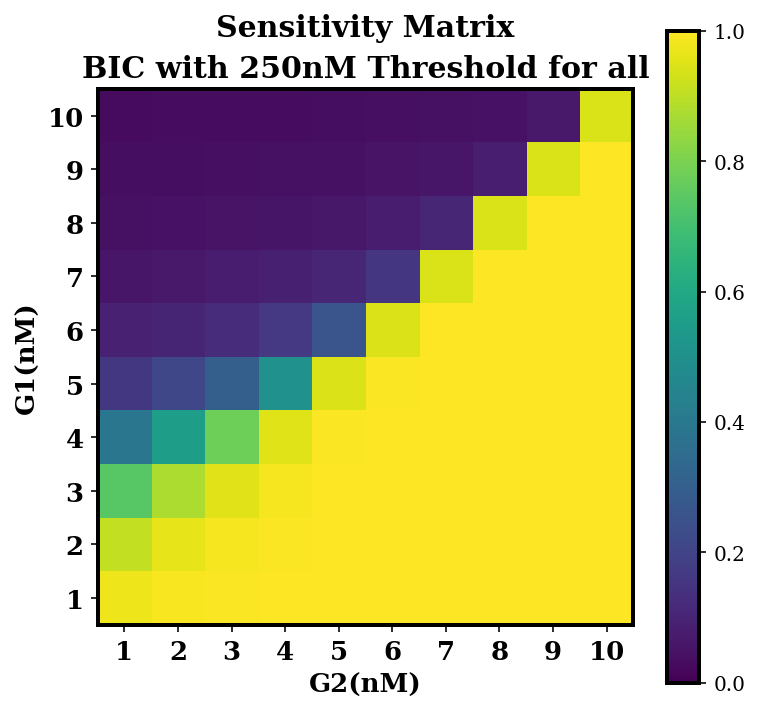

In [148]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5
#         Rs
rep_vec =  [ 1, 2, 3, 1, 2] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-1, 0,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0,-3] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
BIC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3
Thresh_tot = np.array([250,250,250]) # total activator added
#            G1 G2 G3 G4 G5
G_int_vec = [ 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5
        G_tot = np.array([g1, g2, 10, g1, g2]) # total genelet added
        # default of 0 for all other initial conditions
        BIC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        BIC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = BIC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nBIC with 250nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

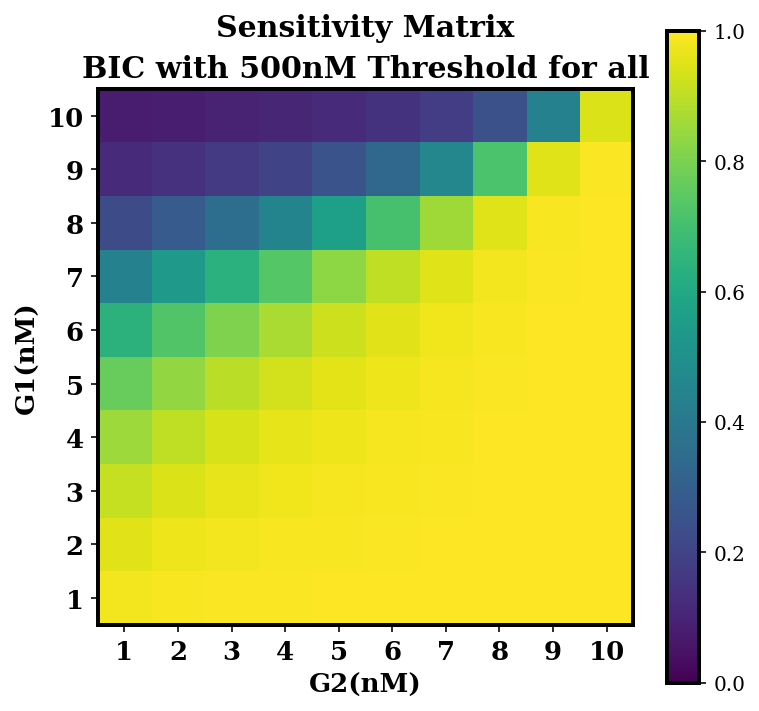

In [149]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5
#         Rs
rep_vec =  [ 1, 2, 3, 1, 2] # vector holding the shared repressors.
#         Rs
rprd_vec = [-2,-1, 0,-3, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0,-3] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
BIC = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3
Thresh_tot = np.array([500,500,500]) # total activator added
#            G1 G2 G3 G4 G5
G_int_vec = [ 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5
        G_tot = np.array([g1, g2, 10, g1, g2]) # total genelet added
        # default of 0 for all other initial conditions
        BIC.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        BIC.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G3 = BIC.output_concentration('Gon3')
        results[ictr][jctr] = G3[-1] / G_tot[2]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix\nBIC with 500nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

## JKComparator 1

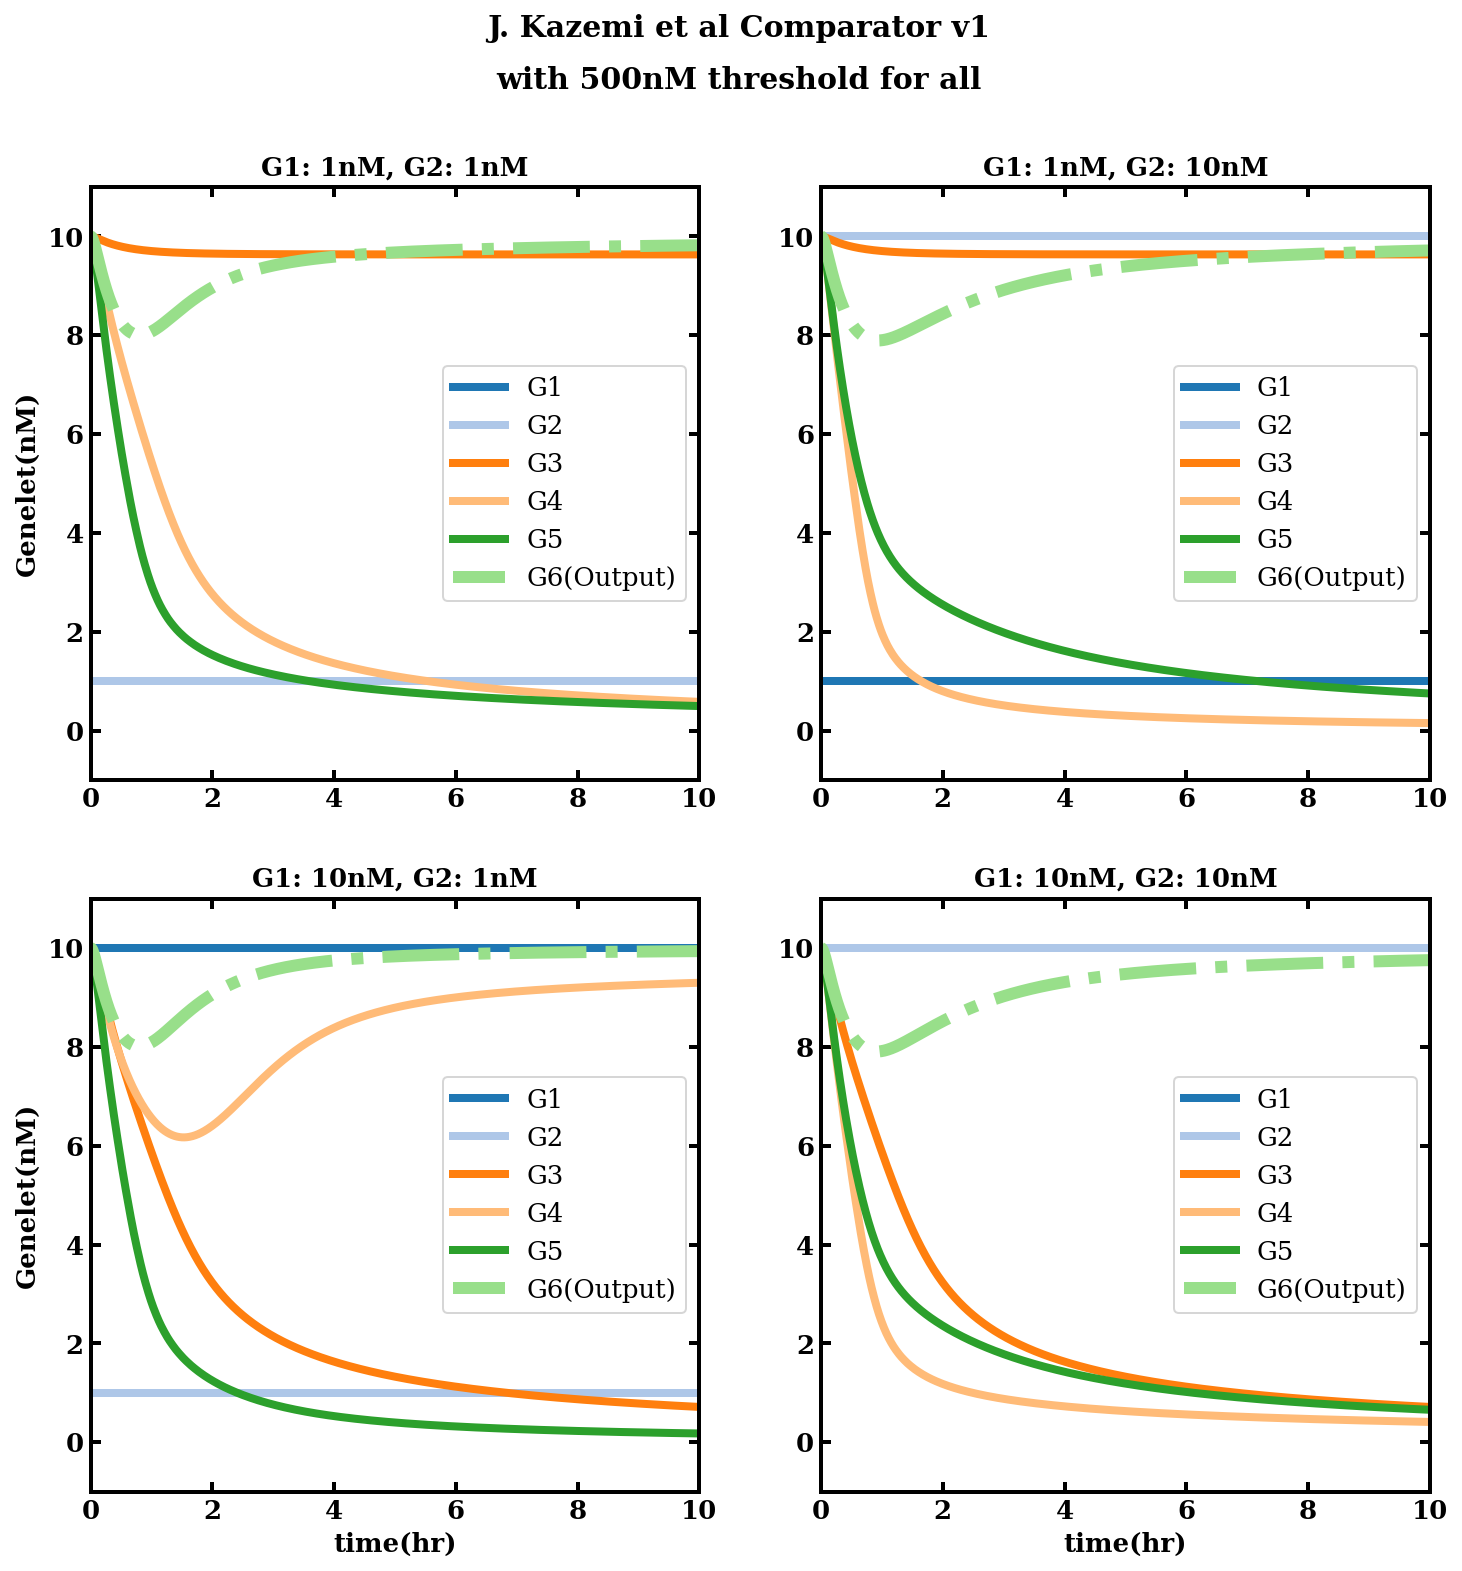

In [165]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-4,-5,-6,-5] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 2 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('J. Kazemi et al Comparator v1\nwith 500nM threshold for all',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = JKCv1.output_concentration('Gon1')
        G2 = JKCv1.output_concentration('Gon2')
        G3 = JKCv1.output_concentration('Gon3')
        G4 = JKCv1.output_concentration('Gon4')
        G5 = JKCv1.output_concentration('Gon5')
        G6 = JKCv1.output_concentration('Gon6')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3")
        ax.plot(sim_t / 3600, G4, color = cm.colors[3], lw = 4, label = "G4")
        ax.plot(sim_t / 3600, G5, color = cm.colors[4], lw = 4, label = "G5")
        ax.plot(sim_t / 3600, G6, color = cm.colors[5], lw = 6, label = "G6(Output)", ls = "-.")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

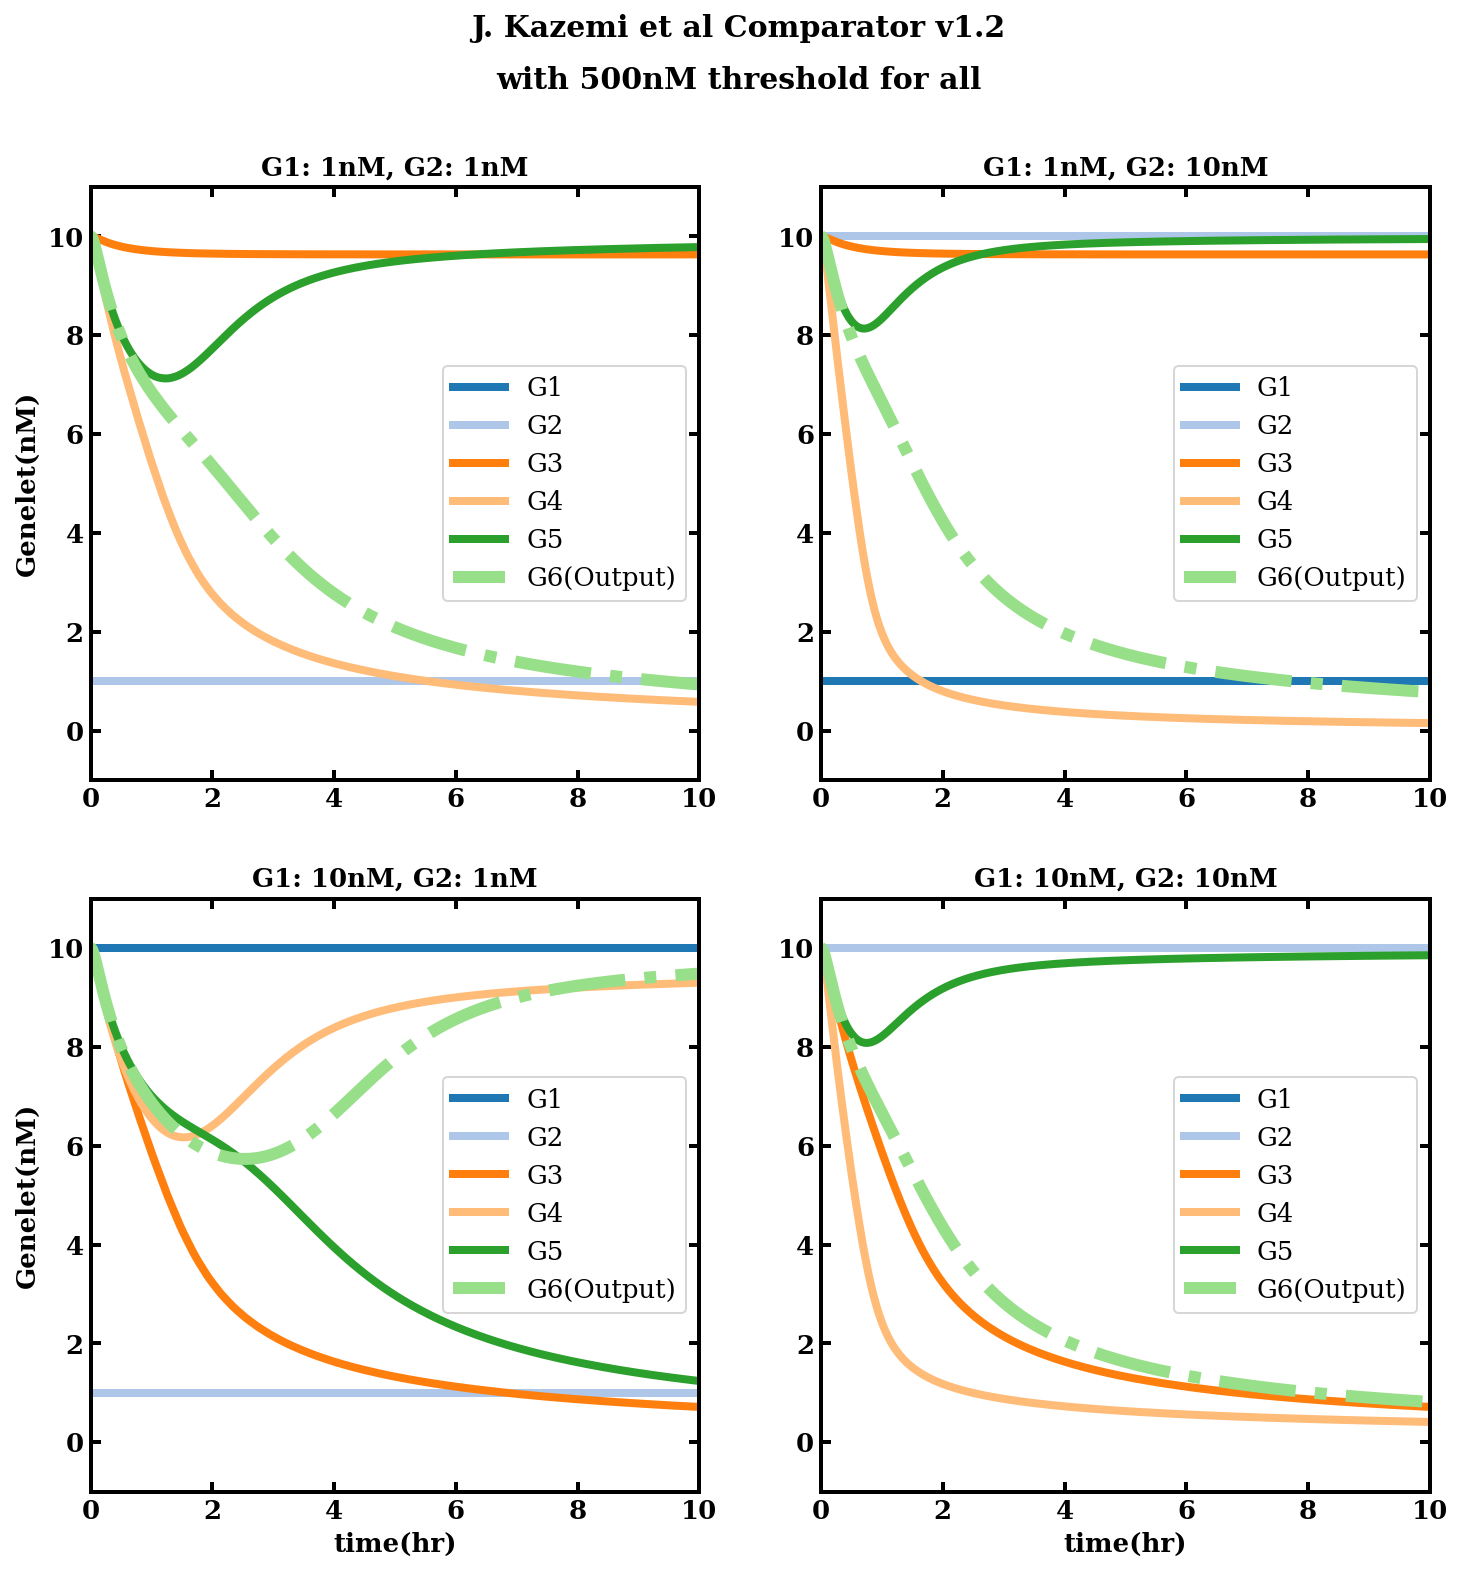

In [164]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-4,-5,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 2 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('J. Kazemi et al Comparator v1.2\nwith 500nM threshold for all',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = JKCv1.output_concentration('Gon1')
        G2 = JKCv1.output_concentration('Gon2')
        G3 = JKCv1.output_concentration('Gon3')
        G4 = JKCv1.output_concentration('Gon4')
        G5 = JKCv1.output_concentration('Gon5')
        G6 = JKCv1.output_concentration('Gon6')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3")
        ax.plot(sim_t / 3600, G4, color = cm.colors[3], lw = 4, label = "G4")
        ax.plot(sim_t / 3600, G5, color = cm.colors[4], lw = 4, label = "G5")
        ax.plot(sim_t / 3600, G6, color = cm.colors[5], lw = 6, label = "G6(Output)", ls = "-.")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

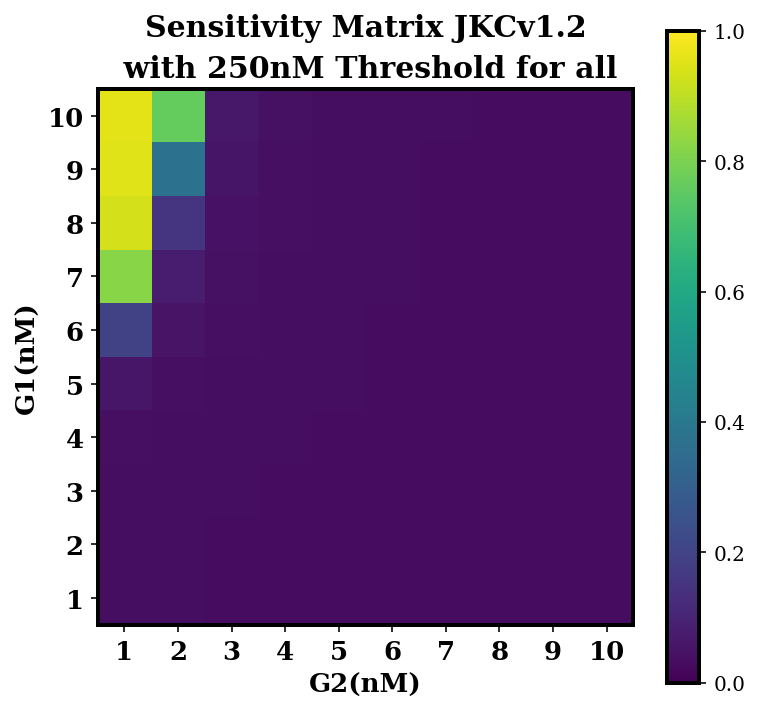

In [180]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-4,-5,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 1 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv1.2\n with 250nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

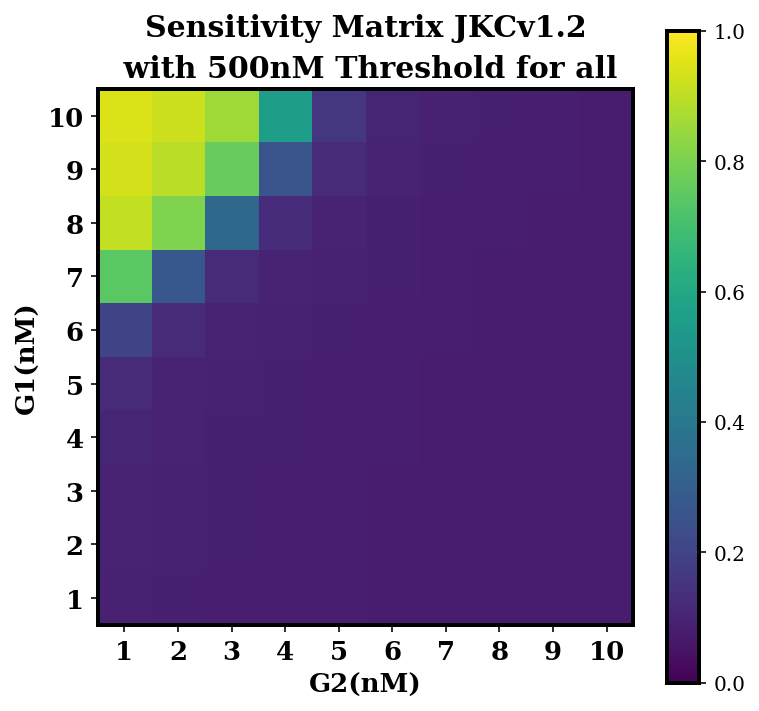

In [181]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-4,-5,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 2 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv1.2\n with 500nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

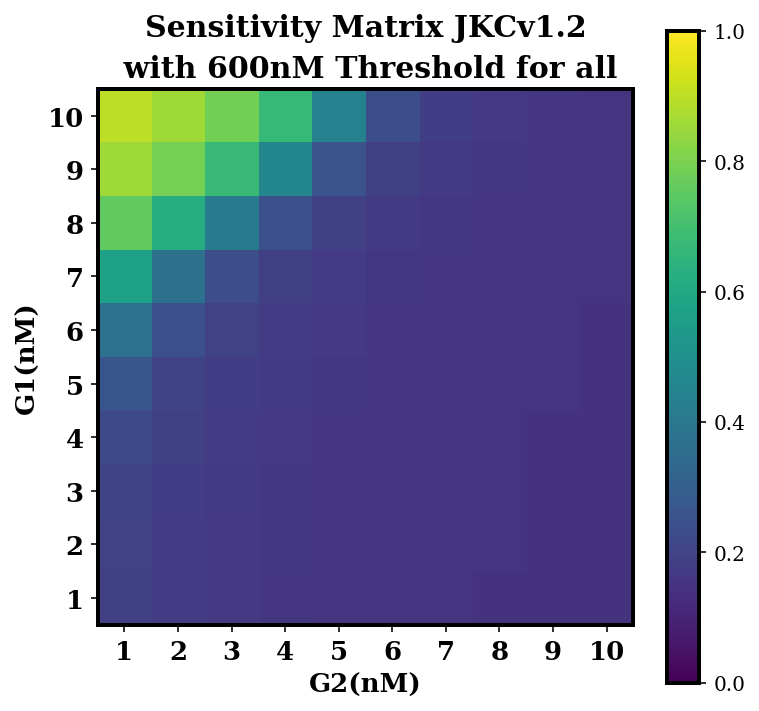

In [182]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-4,-5,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([1,1,1,1,1,1]) * 600 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv1.2\n with 600nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

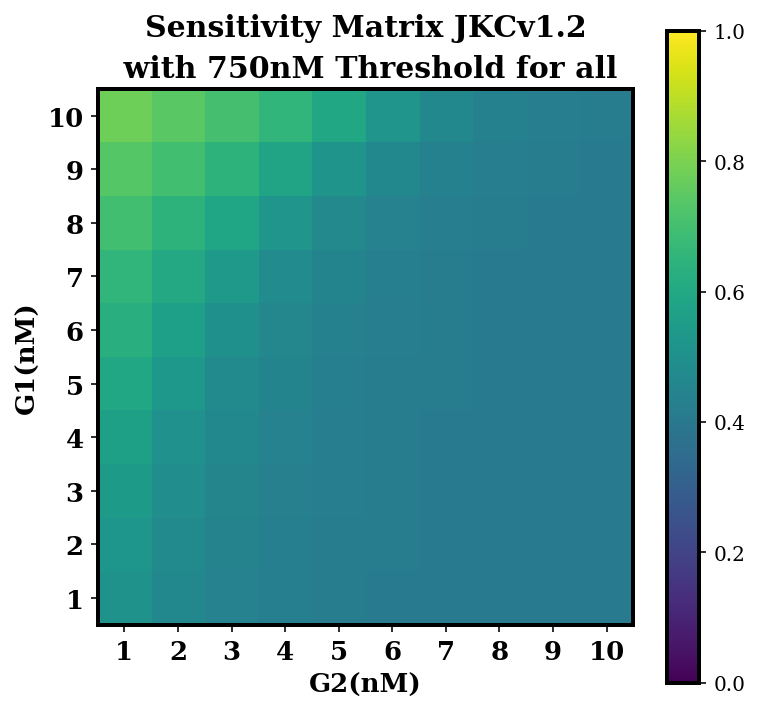

In [183]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-4,-5,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([1,1,1,1,1,1]) * 750 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv1.2\n with 750nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

## JKComparator2

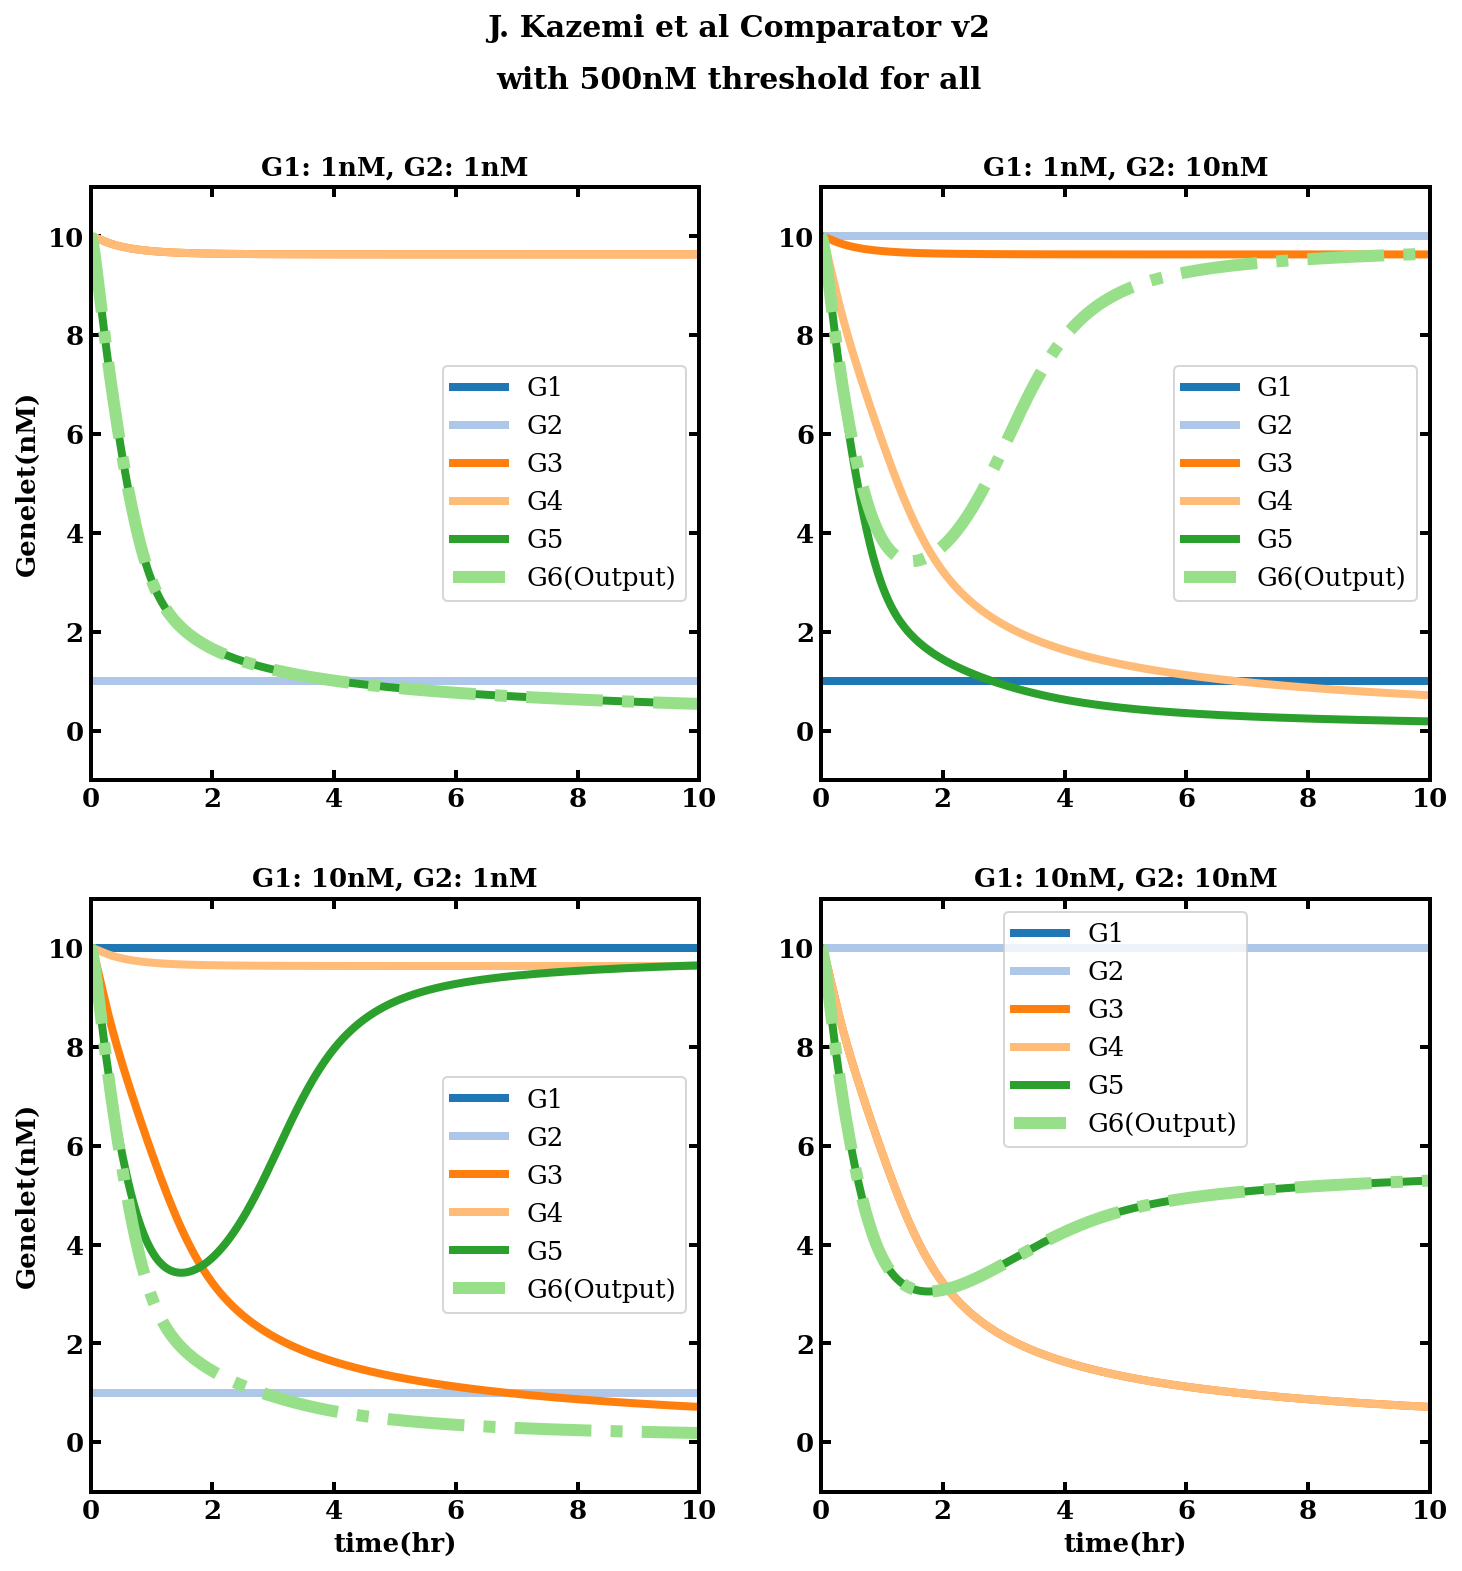

In [192]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-5,-6,-6,-5] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 2 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('J. Kazemi et al Comparator v2\nwith 500nM threshold for all',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = JKCv1.output_concentration('Gon1')
        G2 = JKCv1.output_concentration('Gon2')
        G3 = JKCv1.output_concentration('Gon3')
        G4 = JKCv1.output_concentration('Gon4')
        G5 = JKCv1.output_concentration('Gon5')
        G6 = JKCv1.output_concentration('Gon6')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 4, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3")
        ax.plot(sim_t / 3600, G4, color = cm.colors[3], lw = 4, label = "G4")
        ax.plot(sim_t / 3600, G5, color = cm.colors[4], lw = 4, label = "G5")
        ax.plot(sim_t / 3600, G6, color = cm.colors[5], lw = 6, label = "G6(Output)", ls = "-.")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

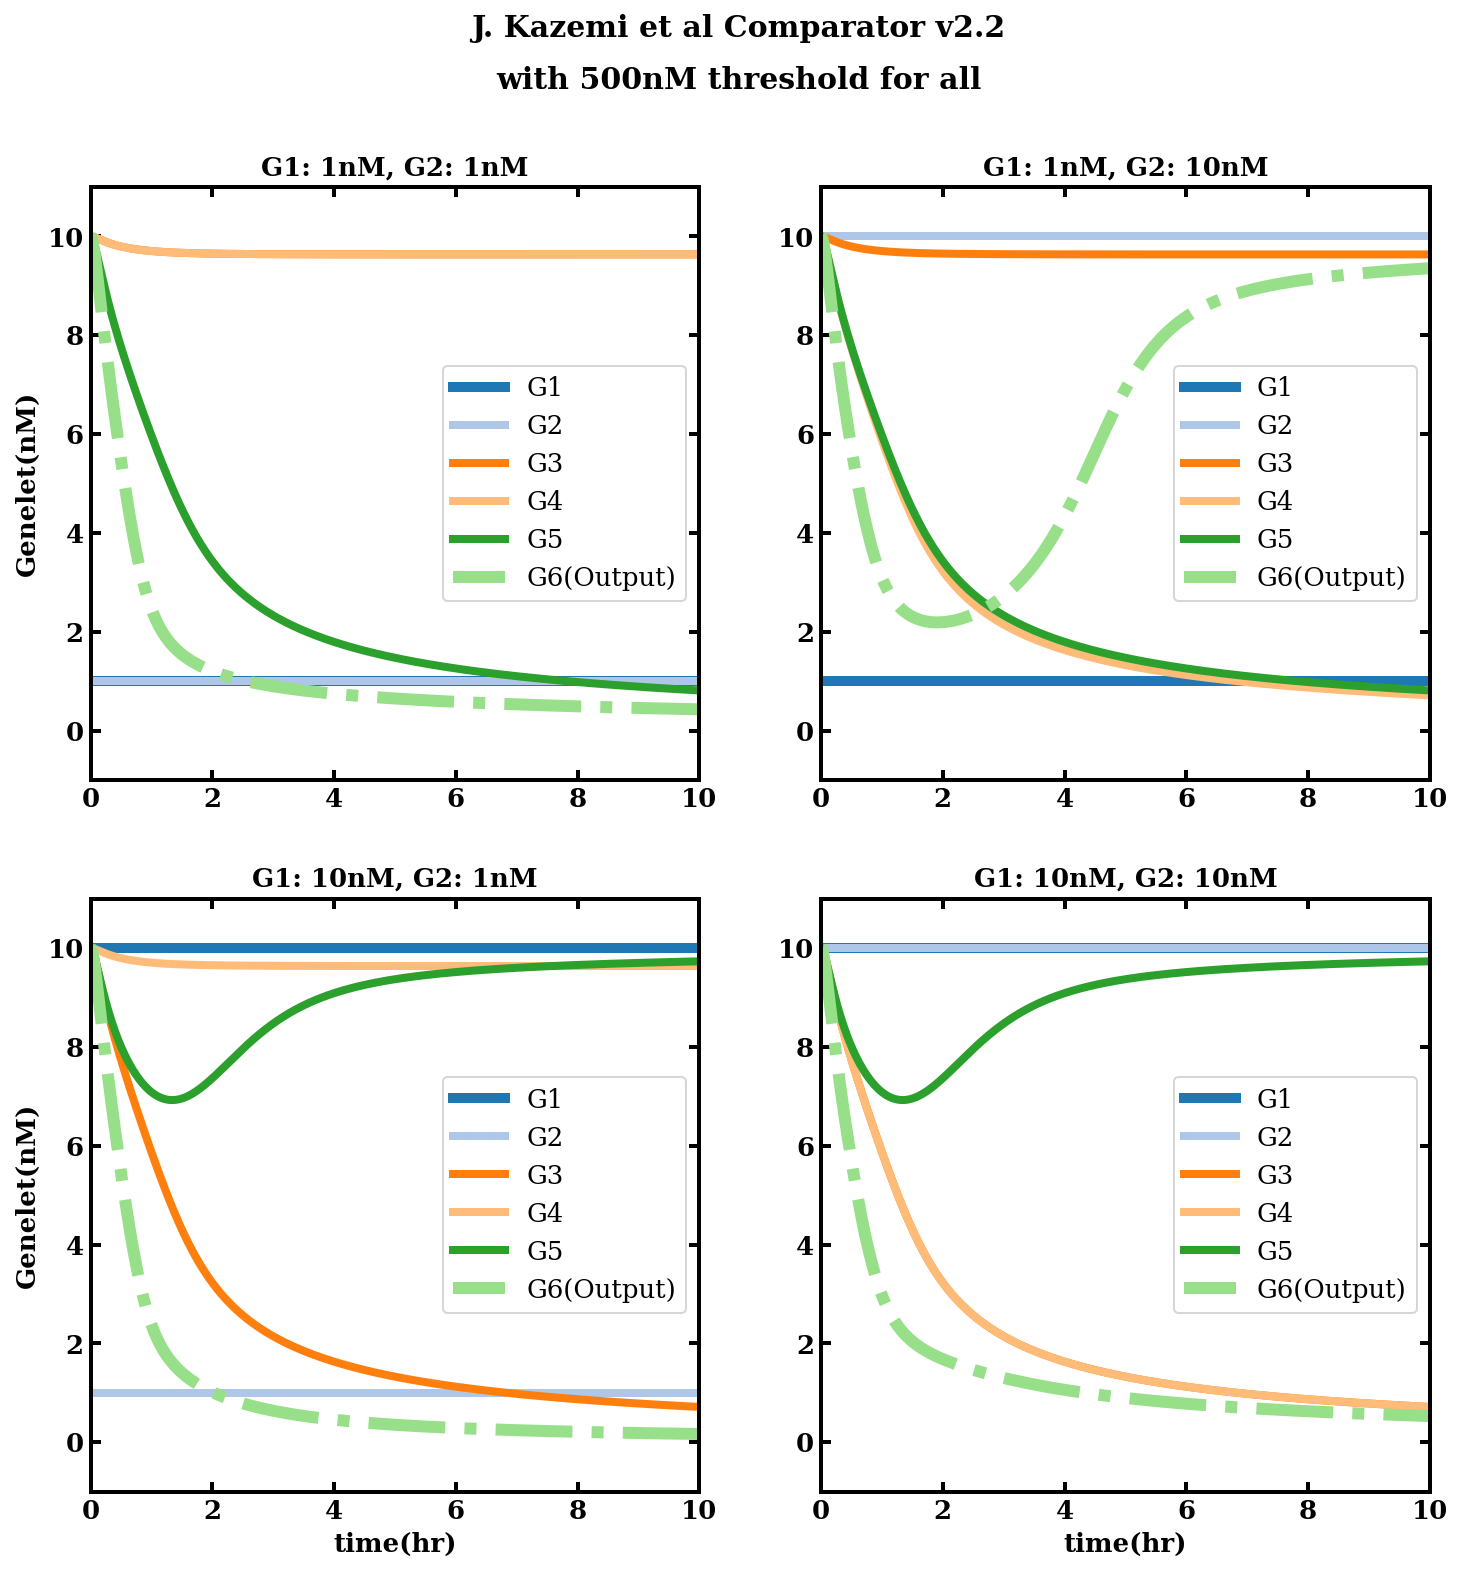

In [193]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-5,-6,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 2 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

fig = plt.figure(figsize = (12, 12)); fs = 13; ctr = 1;
plt.suptitle('J. Kazemi et al Comparator v2.2\nwith 500nM threshold for all',\
             fontsize = fs + 2, weight = 'bold', linespacing = 2)
for g1 in [1, 10]:
    for g2 in [1, 10]:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G1 = JKCv1.output_concentration('Gon1')
        G2 = JKCv1.output_concentration('Gon2')
        G3 = JKCv1.output_concentration('Gon3')
        G4 = JKCv1.output_concentration('Gon4')
        G5 = JKCv1.output_concentration('Gon5')
        G6 = JKCv1.output_concentration('Gon6')
        sim_t = SBSC.sol.t

        ax = plt.subplot(2, 2, ctr)
        ax.set_title("G1: {}nM, G2: {}nM".format(g1, g2), fontsize = fs, weight = 'bold')
        ax.plot(sim_t / 3600, G1, color = cm.colors[0], lw = 5, label = "G1")
        ax.plot(sim_t / 3600, G2, color = cm.colors[1], lw = 4, label = "G2")
        ax.plot(sim_t / 3600, G3, color = cm.colors[2], lw = 4, label = "G3")
        ax.plot(sim_t / 3600, G4, color = cm.colors[3], lw = 4, label = "G4")
        ax.plot(sim_t / 3600, G5, color = cm.colors[4], lw = 4, label = "G5")
        ax.plot(sim_t / 3600, G6, color = cm.colors[5], lw = 6, label = "G6(Output)", ls = "-.")
        plt.xticks(fontsize = fs, weight = 'bold')
        plt.yticks(fontsize = fs, weight = 'bold')
        if ctr in (1, 3):
            ax.set_ylabel('Genelet(nM)', fontsize = fs, weight = 'bold')
        if ctr in (3, 4):
            ax.set_xlabel('time(hr)', fontsize = fs, weight = 'bold')
        ax.legend(fontsize = fs)
        ax.set_xlim(0, 10)
        ax.set_ylim(-1, 11)
        ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
        ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

        ctr += 1

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

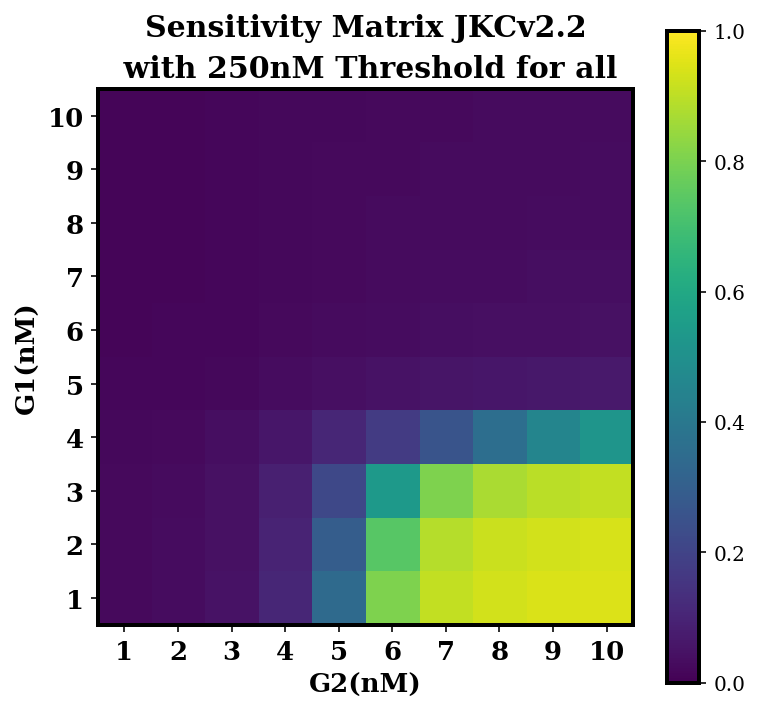

In [188]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-5,-6,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 1 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv2.2\n with 250nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

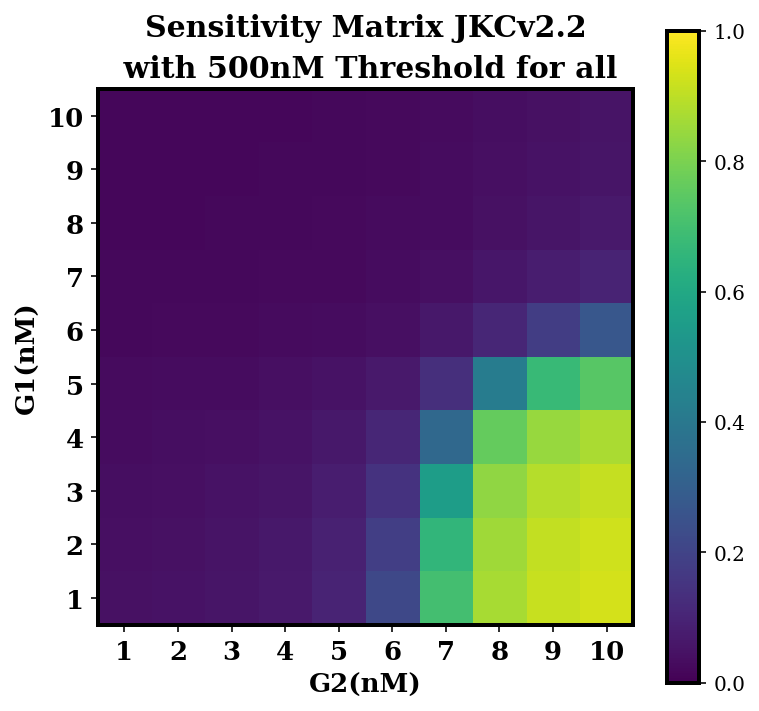

In [189]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-5,-6,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 2 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv2.2\n with 500nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

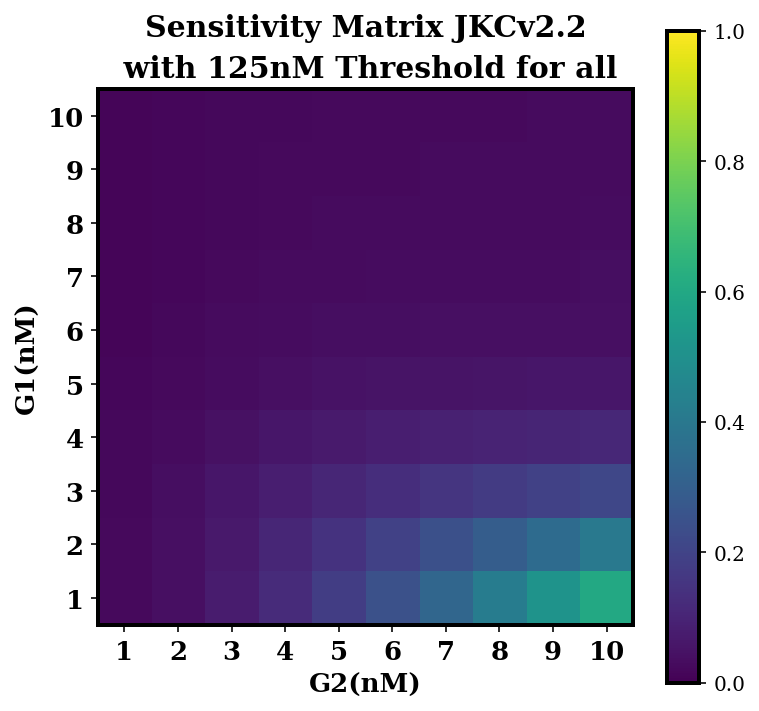

In [190]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-5,-6,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * .5 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv2.2\n with 125nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")

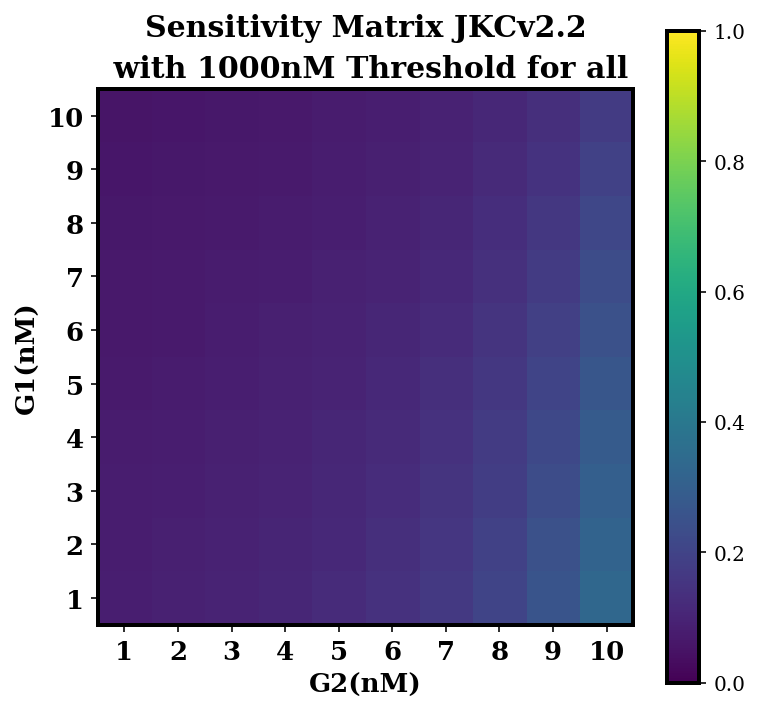

In [191]:
# CONNECTIVITY DEFINITION
#           G1 G2 G3 G4 G5 G6
#         Rs
rep_vec =  [ 1, 2, 3, 4, 5, 6] # vector holding the shared repressors.
#         Rs
rprd_vec = [-3,-4,-5,-6,-6, 0] # genelets producing repressors
#         Is
iprd_vec = [ 0, 0, 0, 0, 0, 0] # inducer I2 would bind with inducer R2, etc...

# blk_vec is not needed as an input here
JKCv1 = GeneletNetwork(rep_vec, rprd_vec, iprd_vec, genelet_type = 'STG')

# INITIAL CONDITIONS
# initial concentrations, unit [nM]
#                      dA1 dA2 dA3 dA4 dA5 dA6
Thresh_tot = np.array([250,250,250,250,250,250]) * 4 # total activator added
#            G1 G2 G3 G4 G5 G6
G_int_vec = [ 1, 1, 1, 1, 1, 1]

snty_array = range(1, 11)
results = np.zeros(shape = (len(snty_array), len(snty_array))); ictr = 0;

for g1 in snty_array:
    jctr = 0;
    for g2 in snty_array:
        #                 G1  G2  G3  G4  G5  G6
        G_tot = np.array([g1, g2, 10, 10, 10, 10]) # total genelet added
        # default of 0 for all other initial conditions
        JKCv1.initial_conditions(Thresh_tot, G_tot, G_int_vec) 
        # Simulation time, unit: seconds
        t_vec1 = np.linspace(0, 10, 1001) * 3600 
        # Use RNase A for ssRNA degradation
        JKCv1.simulate(t_vec1, 1, rnase = 'both')
        # pulling out solutions for plotting from output_concentration attribute
        G6 = JKCv1.output_concentration('Gon6')
        results[ictr][jctr] = G6[-1] / G_tot[5]
        jctr += 1
    ictr += 1

fig = plt.figure(figsize = (6, 6)); fs = 13
plt.title("Sensitivity Matrix JKCv2.2\n with 1000nM Threshold for all",\
          fontsize = fs + 2, weight = 'bold', linespacing = 1.5)
plt.imshow(np.flip(results, 0))
plt.xlabel("G2(nM)", fontsize = fs, weight = 'bold')
plt.ylabel("G1(nM)", fontsize = fs, weight = 'bold')
plt.xticks(range(len(snty_array)), snty_array, fontsize = fs, weight = 'bold');
plt.yticks(np.flip(range(len(snty_array))), snty_array, fontsize = fs, weight = 'bold');
plt.colorbar(); plt.clim(0, 1);

# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png",\
#             dpi = 900, bbox_inches = "tight")